# Larval MB Figures


Jump to [**Larval Mushroom Body**](#Larval-MB)

In [1]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import bokeh
from bokeh.io import output_notebook, output_file, show, save, export_png, export_svgs
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, CategoricalColorMapper,
                          CategoricalMarkerMapper,
                          BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange,
                          Range1d)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet

from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
output_notebook()

import ipyvolume as ipv

import colorcet as cc


from visualization.vis import *
from visualization.vis3d import *
# from visualization.vis import (draw_graph,
#                                circle_layout_graph, breakdown_flowchart_graph,
#                                breakdown_barchart_figure, code_heatmap,
#                                display_dataframe, roi_adj_fig,
#                                tuple_to_string, repeat_to_match_lengths,
#                                poincare_geodesic, outer_loop_circle,
#                                normalize)
from visualization.reduce_graphs import reduced_graph, cluster_codes, subgraph
# from util import log_msg, simplify_type
from util import *

from math import pi

log_msg("Imports complete")

Loading BokehJS ...

2023 06 26 12:13:48  Imports complete


In [26]:
hemibrain_version = "v1.2.1"
preproc_dir = "oviIN/preprocessed_outputs-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "x"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "oviIN/clustering_outputs_" + hemibrain_version
hemibrain_nodes = "only_outputs_key.txt"
hemibrain_edges = "only_outputs.txt"

figure_dir = os.path.join("figures","paper")
movie_dir = os.path.join("movies")
# analysis_dir = os.path.join("analysis",hemibrain_version)
# obj_dir = os.path.join("obj",hemibrain_version)  # 3d objects from, e.g. fetch_roi_mesh
# skel_dir = os.path.join("skeleton", hemibrain_version)  # skeleta of neurons in .csv format


# for d in [figure_dir, analysis_dir, obj_dir, movie_dir]:
#     if not os.path.isdir(d):
#         log_msg("Creating directory", d)
#         os.makedirs(d)

# reneel_params = list(sorted(['0.0', '1.0', '0.5', '0.25', '0.1', '0.05', '0.75'], key=float))
# type_params = ['celltype','instance']
# list_of_params = reneel_params + type_params
reneel_params = list(sorted(['0.0', '0.05','0.1', '0.5', '0.75', '1.0'], key=float))
lreneel_params = reneel_params
#lMB_celltypes = ["KC", "MBIN", "MBON", "PN", "Other"]

log_msg("Set up directory info and useful lists")

2023 06 26 12:15:36  Set up directory info and useful lists


## Load data

In [3]:
#larval_MB_skeletons = pd.read_csv("larval_MB/skeletons.csv")
#larval_MB_skeletons.columns = [c.strip() for c in larval_MB_skeletons.columns]
#larval_MB_skeletons.parent_treenode_id.fillna(-1, inplace=True)
#larval_MB_skeletons.parent_treenode_id = larval_MB_skeletons.parent_treenode_id.astype(int)

#larval_neuron_df = larval_MB_skeletons.groupby("skeleton_id").agg({"neuron":"first", "treenode_id":"count", "x":"mean", "y":"mean", "z":"mean"})
# larval_neuron_df #.reset_index().set_index("skeleton_id")
# with pd.option_context("display.max_rows",1000):
#display(larval_neuron_df.sort_values("neuron"))

In [4]:
log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Adding 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"].apply(simplify_type)
log_msg("Done!")
HB_node_df.head()

2023 06 26 12:13:50  Loading node dataframe
2023 06 26 12:13:50    (without centroids)
2023 06 26 12:13:50  Adding 'type group'
2023 06 26 12:13:50  Done!


,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois,type_group
id,,,,,,,,,,,,,,,,,,,,,
1007402796,1,1,1,1,1,1,1,PS119_R,PS119,245,...,False,Roughly traced,PDM16,301.0,"[25364, 12010, 12544]","{'SNP(R)': {'pre': 100, 'post': 50, 'downstrea...",NaN,"['CAN(R)', 'GOR(R)', 'IB', 'ICL(L)', 'ICL(R)',...","['AVLP(R)', 'CAN(R)', 'IB', 'ICL(L)', 'INP', '...",PS
1007640554,2,2,2,2,2,2,2,IB042_R,IB042,204,...,False,Roughly traced,PDM24,263.0,"[16520, 19387, 6576]","{'SNP(R)': {'pre': 3, 'post': 736, 'downstream...",NaN,"['ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'IB'...","['ATL(R)', 'IB', 'INP', 'SIP(R)', 'SMP(R)', 'S...",IB
1007666180,3,1,3,3,3,3,3,None,None,0,...,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(R)': {'post': 10}, 'SMP(R)': {'post': 10}}",NaN,"['SMP(R)', 'SNP(R)']",[],None
1007735501,4,1,1,1,1,4,4,None,None,79,...,True,Leaves,NaN,NaN,NaN,"{'SNP(R)': {'pre': 31, 'post': 51, 'downstream...",NaN,"['ATL(L)', 'ICL(L)', 'INP', 'SCL(L)', 'SCL(R)'...","['ATL(L)', 'ICL(L)', 'INP', 'SCL(L)', 'SCL(R)'...",None
1008024276,5,3,4,4,4,5,5,FB5N_R,FB5N,499,...,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",FB


In [5]:
log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges), delimiter=' ', header=None).rename(columns={0: "pre", 1:"post"})
log_msg("Done!")

log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[reneel_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[reneel_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])

'''def side(s):
    if "left" in s.lower():
        return "left"
    if "right" in s.lower():
        return "right"
    return "neither"


def ct(s):
    for t in HB_node_df['celltype']:
        if t in s:
            return t
    if "OAN" in s or "DAN" in s:
        return "MBIN"
    return "Other"


HB_node_df["side"] = HB_node_df.neuron.apply(side)
HB_node_df["celltype"] = HB_node_df.neuron.apply(ct)'''
HB_edge_df

2023 06 26 12:13:51  Loading directed edges from csv
2023 06 26 12:13:51  Done!
2023 06 26 12:13:51  Merging in cell info to edge df


,pre,post,2,0.0pre,0.05pre,0.1pre,0.5pre,0.75pre,1.0pre,type_grouppre,0.0post,0.05post,0.1post,0.5post,0.75post,1.0post,type_grouppost
0,203253253,203594164,5,2,2,2,151,232,255,SMP,2,47,53,152,234,256,None
4632,296859399,203594164,1,2,2,2,2,2,2,SMP,2,47,53,152,234,256,None
24745,329566174,203594164,1,3,4,4,70,120,357,OA,2,47,53,152,234,256,None
31345,357224041,203594164,1,2,2,2,227,340,388,LHPV,2,47,53,152,234,256,None
43192,390331583,203594164,1,2,2,2,179,379,435,SMP,2,47,53,152,234,256,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291354,5813026785,704880173,1,4,5,5,316,569,775,SMP,4,3,22,523,3,1054,None
292910,5813040190,1237524538,4,5,6,8,15,589,159,CRE,5,3,22,111,176,197,None
300592,5813058258,1237524538,2,5,6,8,15,210,236,AVLP,5,3,22,111,176,197,None
294656,5813049380,1045504901,1,6,9,16,239,360,807,SIP,6,18,23,3,69,73,None


In [6]:
adj_valid = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges), delimiter=' ', header=None).rename(columns={0: "pre", 1:"post", 2:'weight'})
adj_valid.pivot_table(values='weight', index='pre', columns='post').fillna(0)

post,203253253,203594164,203598466,204958872,205985855,234630133,263674097,264014957,266187342,266187383,...,5901232690,7112613360,7112613371,7112622044,7112624947,7112624972,7112625063,7112625115,7112625126,7112625282
pre,,,,,,,,,,,,,,,,,,,,,
203253253,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203594164,0.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203598466,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204958872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205985855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112622044,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7112624947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7112624972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
HB_edge_df = HB_edge_df.rename(columns={2:'weight'})
HB_node_df = HB_node_df.rename(columns={'key':'weight'})
HB_edge_df

,pre,post,weight,0.0pre,0.05pre,0.1pre,0.5pre,0.75pre,1.0pre,type_grouppre,0.0post,0.05post,0.1post,0.5post,0.75post,1.0post,type_grouppost
0,203253253,203594164,5,2,2,2,151,232,255,SMP,2,47,53,152,234,256,None
4632,296859399,203594164,1,2,2,2,2,2,2,SMP,2,47,53,152,234,256,None
24745,329566174,203594164,1,3,4,4,70,120,357,OA,2,47,53,152,234,256,None
31345,357224041,203594164,1,2,2,2,227,340,388,LHPV,2,47,53,152,234,256,None
43192,390331583,203594164,1,2,2,2,179,379,435,SMP,2,47,53,152,234,256,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291354,5813026785,704880173,1,4,5,5,316,569,775,SMP,4,3,22,523,3,1054,None
292910,5813040190,1237524538,4,5,6,8,15,589,159,CRE,5,3,22,111,176,197,None
300592,5813058258,1237524538,2,5,6,8,15,210,236,AVLP,5,3,22,111,176,197,None
294656,5813049380,1045504901,1,6,9,16,239,360,807,SIP,6,18,23,3,69,73,None


In [8]:
HB_node_df.index

Int64Index([1007402796, 1007640554, 1007666180, 1007735501, 1008024276,
            1008378448, 1008378609, 1008391068, 1008425971, 1008680614,
            ...
             987190785,  987272562,  987833765,  987834099,  987877232,
             987942060,  988269593,  988291460,  988567837,  988909130],
           dtype='int64', name='id', length=3439)

In [9]:
u_larval_edge_df = pd.DataFrame(HB_edge_df, copy=True)
u_larval_edge_df[["pre", "post"]] = np.sort(u_larval_edge_df[["pre", "post"]].values, axis=1)
u_larval_edge_df = u_larval_edge_df.groupby(["pre", "post"]).agg({"weight":"sum"}).reset_index()
# u_larval_edge_df = u_larval_edge_df.merge(larval_node_df, left_on="pre_skeleton_id", right_index=True)
# u_larval_edge_df = u_larval_edge_df.merge(larval_node_df, left_on="post_skeleton_id", right_index=True, suffixes=["_pre", "_post"])
u_larval_edge_df = u_larval_edge_df.merge(HB_node_df, left_on="pre", right_index=True).merge(HB_node_df, left_on="post_x", right_index=True, suffixes=["_1","_2"])
u_larval_edge_df

,pre_1,pre_x,post_x,weight,key_1,0.0_1,0.05_1,0.1_1,0.5_1,0.75_1,...,cropped_2,statusLabel_2,cellBodyFiber_2,somaRadius_2,somaLocation_2,roiInfo_2,notes_2,inputRois_2,outputRois_2,type_group_2
0,203253253,203253253,203594164,5,364,2,2,2,151,232,...,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 95, 'post': 772, 'downstrea...",NaN,"['ATL(L)', 'BU(L)', 'CRE(-ROB,-RUB)(R)', 'CRE(...","['ATL(L)', 'CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)'...",None
1,203253253,203253253,203598466,1,364,2,2,2,151,232,...,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 414, 'post': 405, 'downstre...",NaN,"['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...","['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...",None
192,203594164,203594164,203598466,92,366,2,47,53,152,234,...,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 414, 'post': 405, 'downstre...",NaN,"['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...","['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...",None
2,203253253,203253253,266528086,1,364,2,2,2,151,232,...,False,Roughly traced,PDM07,266.0,"[17474, 27398, 4300]","{'SNP(R)': {'pre': 120, 'post': 416, 'downstre...",NaN,"['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SIP(R)', 'SMP(R)', 'SNP(R)']",SMP
1773,266187480,266187480,266528086,1,380,2,2,2,161,244,...,False,Roughly traced,PDM07,266.0,"[17474, 27398, 4300]","{'SNP(R)': {'pre': 120, 'post': 416, 'downstre...",NaN,"['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SIP(R)', 'SMP(R)', 'SNP(R)']",SMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301703,1138579549,1138579549,1299935493,1,191,5,6,8,74,124,...,NaN,0.5assign,NaN,NaN,NaN,"{'INP': {'post': 11}, 'CRE(R)': {'post': 11}, ...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP']",[],None
304077,1226206190,1226206190,1784881382,1,260,1,1,8,1,169,...,NaN,Orphan,NaN,NaN,NaN,"{'VMNP': {'post': 13}, 'VES(R)': {'post': 13}}",NaN,"['VES(R)', 'VMNP']",[],None
305250,1407139453,1407139453,1784881382,2,304,1,1,7,130,63,...,NaN,Orphan,NaN,NaN,NaN,"{'VMNP': {'post': 13}, 'VES(R)': {'post': 13}}",NaN,"['VES(R)', 'VMNP']",[],None
306123,1629050586,1629050586,1785240458,1,336,1,1,7,71,193,...,NaN,0.5assign,NaN,NaN,NaN,"{'VMNP': {'post': 10}, 'VES(R)': {'post': 10}}",NaN,"['VES(R)', 'VMNP']",[],None


In [10]:
connected_nodes = HB_node_df[HB_node_df["0.0"] > 0]
connected_nodes

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois,type_group
id,,,,,,,,,,,,,,,,,,,,,
1007402796,1,1,1,1,1,1,1,PS119_R,PS119,245,...,False,Roughly traced,PDM16,301.0,"[25364, 12010, 12544]","{'SNP(R)': {'pre': 100, 'post': 50, 'downstrea...",NaN,"['CAN(R)', 'GOR(R)', 'IB', 'ICL(L)', 'ICL(R)',...","['AVLP(R)', 'CAN(R)', 'IB', 'ICL(L)', 'INP', '...",PS
1007640554,2,2,2,2,2,2,2,IB042_R,IB042,204,...,False,Roughly traced,PDM24,263.0,"[16520, 19387, 6576]","{'SNP(R)': {'pre': 3, 'post': 736, 'downstream...",NaN,"['ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'IB'...","['ATL(R)', 'IB', 'INP', 'SIP(R)', 'SMP(R)', 'S...",IB
1007666180,3,1,3,3,3,3,3,None,None,0,...,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(R)': {'post': 10}, 'SMP(R)': {'post': 10}}",NaN,"['SMP(R)', 'SNP(R)']",[],None
1007735501,4,1,1,1,1,4,4,None,None,79,...,True,Leaves,NaN,NaN,NaN,"{'SNP(R)': {'pre': 31, 'post': 51, 'downstream...",NaN,"['ATL(L)', 'ICL(L)', 'INP', 'SCL(L)', 'SCL(R)'...","['ATL(L)', 'ICL(L)', 'INP', 'SCL(L)', 'SCL(R)'...",None
1008024276,5,3,4,4,4,5,5,FB5N_R,FB5N,499,...,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",FB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987942060,3435,5,3,24,635,1097,3,None,None,0,...,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(L)': {'post': 15}, 'SMP(L)': {'post': 15}}",NaN,"['SMP(L)', 'SNP(L)']",[],None
988269593,3436,3,4,4,32,52,54,FB4E_L,FB4E,168,...,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(L)': {'post': 25, 'upstream': 25, 'mito'...",CRELALFB4_1,"['CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB', 'FB-col...","['CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB', 'FB-col...",FB
988291460,3437,4,3,205,745,1098,1322,None,None,2,...,NaN,0.5assign,NaN,NaN,NaN,"{'SNP(L)': {'pre': 2, 'post': 1, 'downstream':...",NaN,"['SMP(L)', 'SNP(L)']","['SMP(L)', 'SNP(L)']",None


## Visualization Helper Code

In [11]:
def fig_out(file=None, title=None):
    if file is None:
        file = 'temp.html'
    if not file.endswith('.html'):
        file = file + '.html'
    if title is None:
        title = file.replace('.html', '').replace('_',' ')
    return {'filename': os.path.join(figure_dir, file), 'title': title}

In [12]:
# palette = np.array(cc.glasbey_light + cc.glasbey + cc.glasbey_dark)
# palette[555] = "#888800"  # This was some obnoxiously bright yellow so I decided to tone it down
# override = {"0.25": {54:cc.glasbey[0]},
#             "0.5": {388: cc.glasbey_bw[41]}}
# celltype_colormap = dict(zip(HB_node_df.celltype.unique(), cycle(palette)))
# celltype_colormap["None"] = "gray"
# typegroup_colormap = dict(zip(HB_node_df.type_group.unique(), cycle(palette)))
# typegroup_colormap["None"] = "gray"
# typegroup_colormap["LC"] = cc.glasbey_bw[7]

# def color_mapper(val, chi="0.0", colors=palette, override=override):
#     if chi == "celltype":
#         default = celltype_colormap.get(val, "gray")
#         return override.get("celltype", {}).get(val, default)
#     elif chi == "type_group":
#         default = typegroup_colormap.get(val, "gray")
#         return override.get("type_group", {}).get(val, default)
#     else:  # chi is one of the reneel params
#         default = colors[val % len(colors)]
#         if val <= 0:
#             return "gray"
#         return override.get(chi, {}).get(val, default)

In [13]:
# "optimized" for the paper figure; propogates colors from left to right
def swap(items, i, j):
    """Swap the elements at positions `i` and `j` in list `items`.
    Returns a copy of the list"""
    if i > j:
        i,j = j,i
    return items[:i] + [items[j]] + items[i+1:j] + [items[i]] + items[j+1:]
    
    
# palette = np.array(cc.glasbey_light + cc.glasbey + cc.glasbey_dark)
# palette = swap(cc.glasbey_light, 35, 38)
palette = cc.glasbey_dark
larval_color_override = {}
def larval_color_mapper(c, chi):
    """Color mapper for clusters of larval MB. Only accepts numerical `c`"""
    skip = sum(HB_node_df[x].max() for x in lreneel_params if float(x) < float(chi))
    default = palette[(c + skip) % len(palette)]
    return larval_color_override.get(chi, {}).get(c, default)

larval_color_override = {"0.25": {1:  larval_color_mapper(1, "0.0"),
                                  7:  larval_color_mapper(2, "0.0"),
                                  3:  larval_color_mapper(3, "0.0"),
                                  11: larval_color_mapper(5, "0.0"),
                                  4:  larval_color_mapper(4, "0.0")}}
larval_color_override["0.5"] = {1:  larval_color_mapper(1, "0.25"),
                                5:  larval_color_mapper(2, "0.25"),
                                4:  larval_color_mapper(3, "0.25"),
                                8:  larval_color_mapper(5, "0.25"),
                                13: larval_color_mapper(7, "0.25"),
                                23: larval_color_mapper(8, "0.25")}

## Miscellaneous utility functions

In [14]:
log_msg("Initialization Complete (presumably)")
log_msg("Versions:")
log_msg("Bokeh:", bokeh.__version__)
log_msg("Colorcet:", cc.__version__)
log_msg("IPyVolume:", ipv.__version__)

2023 06 26 12:13:59  Initialization Complete (presumably)
2023 06 26 12:13:59  Versions:
2023 06 26 12:13:59  Bokeh: 3.1.1
2023 06 26 12:13:59  Colorcet: 3.0.1
2023 06 26 12:13:59  IPyVolume: 0.6.3


# Larval MB
We ran RenEEL with $Q_g$ on the larval mushroom body data

This is the adjacency matrix, as provided by the paper authors.
Unfortunately, I cannot unambiguosly map the labels from this file onto the IDs
in the synapse and skeleton files, so I have to reconstruct this from the source
data.


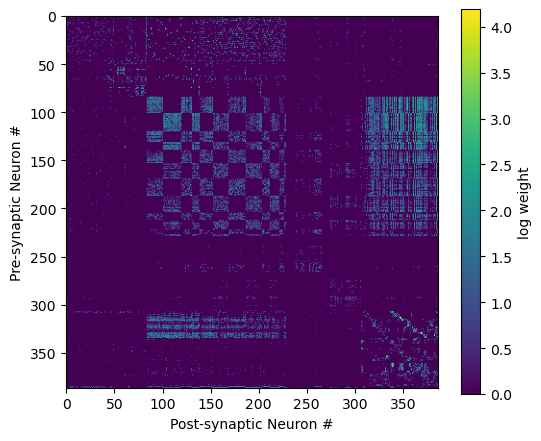

In [15]:
# f = figure(title="Larval MB Adjacency Matrix")
# f.x_range.range_padding = f.y_range.range_padding = 0
# f.image(image=[np.log(adj.values+1)], x=0, y=0, dw=387, dh=387, palette=cc.fire)
# show(f)
adj = pd.read_csv("larval_MB/connectivity matrix table 1.csv", index_col=0)
plt.figure(figsize=(6,5))
plt.imshow(np.log(adj.values+1))
plt.colorbar(label="log weight")
plt.xlabel("Post-synaptic Neuron #")
plt.ylabel("Pre-synaptic Neuron #")
print("""This is the adjacency matrix, as provided by the paper authors.
Unfortunately, I cannot unambiguosly map the labels from this file onto the IDs
in the synapse and skeleton files, so I have to reconstruct this from the source
data.""")

In [15]:
lMB_node_df = HB_node_df
lMB_edge_df = HB_edge_df

In [16]:
chi = "0.0"
lMB_node_df[f"{chi}color"] = [larval_color_mapper(c, chi) for c in lMB_node_df[chi]]
# lMB_node_df["type_color"] = [ctcm.get(c, "gray") for c in lMB_node_df["celltype"]]
connected_nodes = lMB_node_df[lMB_node_df["0.0"] > 0]

In [17]:
lMB_node_df=lMB_node_df.reset_index(inplace=False)

jiahao_order = [s.strip().split()[0] for s in open("oviIN/clustering_outputs_v1.2.1/only_outputs_key.txt").readlines()][::-1]
V = connected_nodes.loc[[int(s) for s in jiahao_order]]
V = pd.concat([V[V.neuron.str.contains("young")], V[~V.neuron.str.contains("young")]])
g = draw_graph(V, u_larval_edge_df, layout="circle",
               edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1, p, q, k=5),
               e_max=0.75,
               edge_start_col="pre_1", edge_end_col="post_x",
               node_fill_by=f"{chi}color", node_fill_mode="custom")

f = figure(x_range=(-1.25, 1.25), y_range=(-1.25, 1.25),
           width=900, height=900)
f.renderers.append(g)
f.add_tools(TapTool(), HoverTool(tooltips={"Cell":"@neuron", "Cluster":"@{0.0}", "Type":"@celltype"}))

for i in lMB_node_df[lMB_node_df.instance.str.contains("i1")].index:
    p = np.array(g.layout_provider.graph_layout[i])
    f.add_layout(Arrow(end=NormalHead(),
                       x_start=1.2*p[0], y_start=1.2*p[1],
                       x_end=1.05*p[0], y_end=1.05*p[1]))

show(f)

In [18]:
lMB_node_df

,id,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,...,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois,type_group,0.0color
0,1007402796,1,1,1,1,1,1,1,PS119_R,PS119,...,Roughly traced,PDM16,301.0,"[25364, 12010, 12544]","{'SNP(R)': {'pre': 100, 'post': 50, 'downstrea...",NaN,"['CAN(R)', 'GOR(R)', 'IB', 'ICL(L)', 'ICL(R)',...","['AVLP(R)', 'CAN(R)', 'IB', 'ICL(L)', 'INP', '...",PS,#8c3bff
1,1007640554,2,2,2,2,2,2,2,IB042_R,IB042,...,Roughly traced,PDM24,263.0,"[16520, 19387, 6576]","{'SNP(R)': {'pre': 3, 'post': 736, 'downstream...",NaN,"['ATL(R)', 'CRE(-ROB,-RUB)(R)', 'CRE(R)', 'IB'...","['ATL(R)', 'IB', 'INP', 'SIP(R)', 'SMP(R)', 'S...",IB,#018700
2,1007666180,3,1,3,3,3,3,3,None,None,...,0.5assign,NaN,NaN,NaN,"{'SNP(R)': {'post': 10}, 'SMP(R)': {'post': 10}}",NaN,"['SMP(R)', 'SNP(R)']",[],None,#8c3bff
3,1007735501,4,1,1,1,1,4,4,None,None,...,Leaves,NaN,NaN,NaN,"{'SNP(R)': {'pre': 31, 'post': 51, 'downstream...",NaN,"['ATL(L)', 'ICL(L)', 'INP', 'SCL(L)', 'SCL(R)'...","['ATL(L)', 'ICL(L)', 'INP', 'SCL(L)', 'SCL(R)'...",None,#8c3bff
4,1008024276,5,3,4,4,4,5,5,FB5N_R,FB5N,...,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",FB,#00acc6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,987942060,3435,5,3,24,635,1097,3,None,None,...,0.5assign,NaN,NaN,NaN,"{'SNP(L)': {'post': 15}, 'SMP(L)': {'post': 15}}",NaN,"['SMP(L)', 'SNP(L)']",[],None,#ff7ed1
3435,988269593,3436,3,4,4,32,52,54,FB4E_L,FB4E,...,Roughly traced,AVM08,NaN,NaN,"{'SNP(L)': {'post': 25, 'upstream': 25, 'mito'...",CRELALFB4_1,"['CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB', 'FB-col...","['CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB', 'FB-col...",FB,#00acc6
3436,988291460,3437,4,3,205,745,1098,1322,None,None,...,0.5assign,NaN,NaN,NaN,"{'SNP(L)': {'pre': 2, 'post': 1, 'downstream':...",NaN,"['SMP(L)', 'SNP(L)']","['SMP(L)', 'SNP(L)']",None,#e6a500
3437,988567837,3438,5,6,8,32,52,1321,FB4G_R,FB4G,...,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",FB,#ff7ed1


In [22]:
# jiahao_order = [s.strip() for s in open("larval_MB/order.txt").readlines()]
jiahao_order = [s.strip().split()[0] for s in open("oviIN/clustering_outputs_v1.2.1/only_outputs_key.txt").readlines()][::-1]
#lMB_node_df["order"] = -1
#lMB_node_df.loc[[int(s) for s in jiahao_order], "order"] = list(range(connected_nodes.shape[0]))

In [23]:
connected_nodes = lMB_node_df[lMB_node_df["0.0"] > 0]

In [24]:
def adj_matrix_bokeh(edges, chi,
                     u_col="pre_str", v_col="post_str", weight_col="weight",
                     color_palette=cc.gray,
                     suffixes=["pre", "post"], directed=True,
                     line_width=0.75,
                     order=jiahao_order,
                     title=None, xlabel="Presynaptic Neuron", ylabel="Postsynaptic Neuron",
                     color_mapper_override={},
                     **figure_kws):
    color_col = f"color{suffixes[0]}"
    edges[color_col] = [larval_color_mapper(c, chi) for c in edges[f"{chi}{suffixes[0]}"]]
    f = figure(title=title,
               x_range=FactorRange(factors=order),
               y_range=FactorRange(factors=list(reversed(order))),
               x_axis_location="above",
               outline_line_color=None,
               border_fill_color=None,
               background_fill_color=None, background_fill_alpha=0.0,
               **figure_kws)
    f.xaxis.axis_label = xlabel
    f.yaxis.axis_label = ylabel
    cm = log_cmap(weight_col, color_palette, 1, edges[weight_col].max())
    # cross-cluster edges
    f.rect(x=u_col, y=v_col, width=1, height=1,
           fill_color=cm,
           line_color=None,
           source=edges[edges[f"{chi}{suffixes[0]}"] != edges[f"{chi}{suffixes[1]}"]])
    if not directed:
        f.rect(x=v_col, y=u_col, width=1, height=1,
               fill_color=cm,
               line_color=None,
               source=edges[edges[f"{chi}{suffixes[0]}"] != edges[f"{chi}{suffixes[1]}"]])
    
    # within-cluster edges
    f.rect(x=u_col, y=v_col, width=1, height=1,
           fill_color=cm,
           line_color=color_col, line_width=line_width,
           source=edges[edges[f"{chi}{suffixes[0]}"] == edges[f"{chi}{suffixes[1]}"]])
    if not directed:
        f.rect(x=v_col, y=u_col, width=1, height=1,
               fill_color=cm,
               line_color=color_col, line_width=line_width,
               source=edges[edges[f"{chi}{suffixes[0]}"] == edges[f"{chi}{suffixes[1]}"]])
    
    f.grid.visible = False
#     f.xaxis.visible = False
#     f.xaxis.axis_line_width=1
#     f.xaxis.axis
#     f.yaxis.visible = False
    f.xaxis.major_label_text_font_size = "0pt"
#     f.xaxis.ticker = FixedTicker(ticks=[1, 360])
    f.xaxis.major_tick_line_color = None
#     f.yaxis.ticker = [1, 360]
    f.yaxis.major_tick_line_color = None
    f.yaxis.major_label_text_font_size = "0pt"
    f.background_fill_color = color_palette[0]
    return f

In [25]:
u_larval_edge_df

,pre_1,pre_x,post_x,weight,key_1,0.0_1,0.05_1,0.1_1,0.5_1,0.75_1,...,cropped_2,statusLabel_2,cellBodyFiber_2,somaRadius_2,somaLocation_2,roiInfo_2,notes_2,inputRois_2,outputRois_2,type_group_2
0,203253253,203253253,203594164,5,364,2,2,2,151,232,...,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 95, 'post': 772, 'downstrea...",NaN,"['ATL(L)', 'BU(L)', 'CRE(-ROB,-RUB)(R)', 'CRE(...","['ATL(L)', 'CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)'...",None
1,203253253,203253253,203598466,1,364,2,2,2,151,232,...,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 414, 'post': 405, 'downstre...",NaN,"['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...","['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...",None
192,203594164,203594164,203598466,92,366,2,47,53,152,234,...,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 414, 'post': 405, 'downstre...",NaN,"['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...","['ATL(L)', 'BU(L)', 'CRE(-RUB)(L)', 'CRE(L)', ...",None
2,203253253,203253253,266528086,1,364,2,2,2,151,232,...,False,Roughly traced,PDM07,266.0,"[17474, 27398, 4300]","{'SNP(R)': {'pre': 120, 'post': 416, 'downstre...",NaN,"['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SIP(R)', 'SMP(R)', 'SNP(R)']",SMP
1773,266187480,266187480,266528086,1,380,2,2,2,161,244,...,False,Roughly traced,PDM07,266.0,"[17474, 27398, 4300]","{'SNP(R)': {'pre': 120, 'post': 416, 'downstre...",NaN,"['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SIP(R)', 'SMP(R)', 'SNP(R)']",SMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301703,1138579549,1138579549,1299935493,1,191,5,6,8,74,124,...,NaN,0.5assign,NaN,NaN,NaN,"{'INP': {'post': 11}, 'CRE(R)': {'post': 11}, ...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP']",[],None
304077,1226206190,1226206190,1784881382,1,260,1,1,8,1,169,...,NaN,Orphan,NaN,NaN,NaN,"{'VMNP': {'post': 13}, 'VES(R)': {'post': 13}}",NaN,"['VES(R)', 'VMNP']",[],None
305250,1407139453,1407139453,1784881382,2,304,1,1,7,130,63,...,NaN,Orphan,NaN,NaN,NaN,"{'VMNP': {'post': 13}, 'VES(R)': {'post': 13}}",NaN,"['VES(R)', 'VMNP']",[],None
306123,1629050586,1629050586,1785240458,1,336,1,1,7,71,193,...,NaN,0.5assign,NaN,NaN,NaN,"{'VMNP': {'post': 10}, 'VES(R)': {'post': 10}}",NaN,"['VES(R)', 'VMNP']",[],None


In [ ]:
np.setdiff1d(lreneel_params,['0.05','0.1', '0.5', '0.75', '1.0'])

In [ ]:

# larval_color_override = {"0.25": {1: larval_color_mapper}}

u_larval_edge_df["pre_str"] = u_larval_edge_df.pre_1.apply(str)
u_larval_edge_df["post_str"] = u_larval_edge_df.post_x.apply(str)
fs = []
# for chi in ["0.0", "0.25", "0.5"]:
for chi in np.setdiff1d(lreneel_params,['0.05','0.1', '0.5', '0.75', '1.0']):
    f = adj_matrix_bokeh(u_larval_edge_df, chi, color_palette=cc.gray[::-1],
                         suffixes=["_1", "_2"], directed=False,
#                          xlabel="Neuron 1", ylabel="Neuron 2",
                         xlabel=None, ylabel=None,
                         width=500, height=500)
#     f.xaxis.axis_label = "Neuron"
#     f.xaxis.axis_label_text_font_size = "14pt"
#     f.xaxis.axis_label_text_font_style = "normal"
#     f.yaxis.axis_label = "Neuron"
#     f.yaxis.axis_label_text_font_size = "14pt"
#     f.yaxis.axis_label_text_font_style = "normal"
    f.axis.axis_label_text_font_size = "14pt"
    f.axis.axis_label_text_font_style = "normal"
    f.add_tools(HoverTool(tooltips={"Pre": "@pre_skeleton_id", "Post":"@post_skeleton_id", "Clusters": "@{"+chi+"_1} -> @{"+chi+"_2}"}))
    fs.append(f)
show(gridplot(fs, ncols=1, width=400, height=400))
#show(fs, width=400, height=400)

In [31]:
ctcm = dict(zip(lMB_celltypes, bokeh.palettes.Pastel1_9))
def recolor(id_mesh, chi, node_df):
    if chi in reneel_params:
        for b, m in id_mesh:
            m.color = larval_color_mapper(node_df.loc[b, chi], chi)
    else:
        for b, m in id_mesh:
            m.color = ctcm.get(node_df.loc[b, chi], "#444444")

In [36]:
chi = "0.0"

ipv.figure()
ipv.show()
meshes = []
for neuron, r in connected_nodes.iterrows():
    s = format_skeleton(larval_MB_skeletons[larval_MB_skeletons.skeleton_id == neuron],
                        "treenode_id", "parent_treenode_id")
    m = ipv.plot_trisurf(s.x, s.y, s.z,
                         lines=s[s.parent != -1][["node","parent"]].values,
                         color=larval_color_mapper(r[chi], chi))
    meshes.append((neuron, m))


ipv.view(-14.837017981146845, 25.033067681206358, 1.9999999999999756)
ipv.style.axes_off()
ipv.style.box_off()
ipv.squarelim()
# ipv.savefig(os.path.join(figure_dir,"Larval MB","larval-MB-3d-anterior-chi-000.png"),
#             width=2000, height=2000, fig=ipv.gcf(), )
th = np.pi/24
cth, sth = np.cos(th), np.sin(th)
plot_axis_key([50000, 10000, 30000], 8000, 600, axis_shift=-0.4,
              u=[cth,sth,0], v=[0,0,-1], w=[-sth,cth,0])

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [37]:
ipv.style.axes_on()

In [107]:
recolor(meshes, "0.0", connected_nodes)

In [108]:
for chi in ["0.0", "0.25", "0.5"]:
    log_msg(f"Recoloring with {chi = }")
    recolor(meshes, chi, connected_nodes)
    log_msg("Saving figure")
    s = chi.replace(".", "")
    s = s + "0" * (3 - len(s))
    filename = os.path.join(figure_dir, "6 Larval MB", f"larval-MB-3d-anterior-chi-{s}.png")
    ipv.savefig(filename,
                width=2000, height=2000, fig=ipv.gcf())
    log_msg("Cropping figure")
    simple_crop(filename, add_name="")
    log_msg(f"Finished {chi = }")

2022 10 25 13:30:47  Recoloring with chi = '0.0'
2022 10 25 13:30:47  Saving figure


Output()

In [21]:
# from bokeh.transform import factor_hatch

# ctcm = dict(zip(lMB_celltypes, bokeh.palettes.Pastel1_9))

def celltype_bars_bokeh(nodes, chi, grouper="celltype", groups=lMB_celltypes,
                        min_size=0,
                        order="size",
                        orientation="horizontal", x_axis_location="below",
                        title="Cell type distribution",
                        xlabel="# Neurons", ylabel="Cluster",
                        include_legend=True, legend_location=None,
                        bar_width=0.75, box_size=10):
    fig_kws = dict(title=title,
                   x_axis_location=x_axis_location,
                   border_fill_color=None,
                   outline_line_color=None,
                   background_fill_color=None)
    h = figure(**fig_kws)
    
    jm = joint_marginal(nodes, chi, grouper)
    jm = jm[jm[f"{chi}_count"] >= min_size]
    max_size = jm[f"{chi}_count"].max()
    print(f"Largest cluster found is {max_size}")
    jm = jm.pivot_table(values="joint_count", index=chi, columns=grouper, fill_value=0).reset_index()
    if order == "size":
        jm["order"] = rankdata(-jm[groups].values.sum(axis=1), method="ordinal")
    elif order == "annealed":
        jm["order"] = np.argsort(nodes.groupby(chi).agg({"order":"mean"}).sort_values("order").index)
    else:
        jm["order"] = range(jm.shape[0])
    jm["cluster_color"] = [larval_color_mapper(c, chi) for c in jm[chi]]
    if groups is None:
        groups = jm[grouper].unique().tolist()
    stack_kws = dict(color=bokeh.palettes.Pastel1_9[:len(groups)],
#                      bokeh.palettes.Category10_10[:len(groups)],
#                      hatch_pattern=["v", ",", "`", "|", "o"],
#                      hatch_scale=5,
#                      line_color="black",line_width=1,
                     source=jm)
    if include_legend:
        stack_kws["legend_label"] = groups
    if orientation == "horizontal":
#         stack_kws["y"] = "order"
        h.hbar_stack(groups, y="order", height=bar_width, **stack_kws)
    else:
#         stack_kws["x"] = "order"
        h.vbar_stack(groups, x="order", width=bar_width, **stack_kws)
#     h.hbar(y="rank",
#            left=-10, right=-5,
#            height=bar_width,
#            color="cluster_color",
#            source=jm)
    for r, c in zip(jm["order"], jm["cluster_color"]):
        if orientation == "horizontal":
            box_kws = dict(top=r+bar_width/2, bottom=r-bar_width/2,
                           right=15, right_units="screen",)
#                            left=5, left_units="screen")
        else:
            box_kws = dict(left=r-bar_width/2, right=r+bar_width/2, top=box_size, top_units="screen")
        box = BoxAnnotation(fill_color=c, fill_alpha=1.0, **box_kws)
        h.add_layout(box)
    h.grid.visible = False
    if orientation == "horizontal":
        h.xaxis.axis_label = xlabel
        h.xaxis.minor_tick_line_color = None
        h.xaxis.ticker = FixedTicker(ticks=[0, (max_size//10) * 10])
        
        h.yaxis.axis_label = ylabel
        h.yaxis.major_label_text_font_size = "0pt"
        h.yaxis.major_tick_line_color = None
        h.yaxis.minor_tick_line_color = None
    else:
        h.yaxis.axis_label = xlabel
        h.yaxis.minor_tick_line_color = None
        h.xaxis.axis_label = ylabel
        h.xaxis.major_label_text_font_size = "0pt"
        h.xaxis.major_tick_line_color = None
        h.xaxis.minor_tick_line_color = None
    if include_legend and legend_location is not None:
        h.legend.location = legend_location
    
    h.add_tools(HoverTool(tooltips={"Cluster, Celltype":"@{"+chi+"}, $name", "Count":"@$name"}))
    return h

In [14]:
orient = "horizontal"
order = "size"
hs = []
for chi in lreneel_params:
# for chi in ["0.0", "0.25", "0.5"]:
    add_legend = chi in ["0.1", "0.5"]
#     add_legend = False
    f = celltype_bars_bokeh(connected_nodes, chi, order=order, orientation=orient,
                            min_size=0,
                            title=f"Chi = {chi}", include_legend=add_legend)
    # f.xaxis.axis_label_text_font_size = "14pt"
    f.axis.axis_label_text_font_size = "14pt"
    f.axis.axis_label_text_font_style = "normal"
    if orient == "horizontal":
        f.xaxis.major_label_text_font_size = "14pt"
    else:
        f.yaxis.major_label_text_font_size = "14pt"
    if add_legend:
        f.legend.title = "Cell Type"
        f.legend.title_text_font_size = "24pt"
        f.legend.title_text_font_style = "normal"
        f.legend.label_text_font_size="24pt"
        f.legend.border_line_color = None
        
    f.add_layout(Span(location=0, dimension="height", line_color="black", line_width=2))
    f.yaxis.axis_line_color=None
    f.xaxis.bounds = (0, 200)
    f.xaxis.axis_line_width=2
    f.xaxis.major_tick_line_width=2
#     f.axis.major_label_text_font_size = "0pt"
#     f.axis.axis_label_text_font_size = "0pt"
    hs.append(f)
    
#     f.title.text = 
    f.title.text_font_size = "24pt"
show(gridplot(hs, ncols=3, plot_width=500, plot_height=500))
# save(gridplot(hs, ncols=3, plot_width=500, plot_height=500),
#      filename=os.path.join(figure_dir, "6 Larval MB", "celltype_barcharts.html"),
#      title="Larval MB Cell Types")

NameError: name 'celltype_bars_bokeh' is not defined

In [ ]:
sum(connected_nodes[chi].max() for chi in ["0.0", "0.25", "0.5"])

In [ ]:
show(gridplot([fs, hs], plot_width=400, plot_height=400))

In [ ]:
edges = lMB_edge_df.merge(connected_nodes["celltype"], left_on="pre_skeleton_id", right_index=True).merge(connected_nodes["celltype"], left_on="post_skeleton_id", right_index=True, suffixes=["pre","post"])
df = edges.groupby(["pre_skeleton_id","celltypepre","celltypepost"]).agg({"post_skeleton_id":"count", "weight":"mean"}).reset_index()
s = connected_nodes.value_counts("celltype")
s.name = "celltype_count"
df = df.merge(s, left_on="celltypepre", right_index=True).merge(s, left_on="celltypepost", right_index=True, suffixes=["pre","post"])
df["post_type_fraction"] = df["post_skeleton_id"] / df["celltype_countpost"]
df = df.merge(connected_nodes[lreneel_params], left_on="pre_skeleton_id", right_index=True)
df[df.celltypepre == "KC"]
# agg({"weight":["count","sum","mean","max","min"]})

In [ ]:
df_KC_MBON = df[(df.celltypepre=="KC") & (df.celltypepost == "MBON")]
# plt.figure()
# plt.title("Overall distribution")
# plt.hist(df_KC_MBON["post_type_fraction"],bins=np.linspace(0,1,11))
# plt.xlabel("Fraction of MBONs postsyn to KCs")
# plt.ylabel("Number of KCs")

# for chi in lreneel_params:
#     plt.figure()
#     plt.title(f"Per-cluster distribution for {chi = }")
#     plt.xlabel("Fraction of MBONs postsyn to KCs")
#     plt.ylabel("Number of KCs")
#     for c in df[chi].unique():
#         plt.hist(df_KC_MBON[df_KC_MBON[chi] == c]["post_type_fraction"], bins=np.linspace(0,1,11), color=color_mapper(c, chi), alpha=0.5)
f_all = figure(title="KC to MBON connections")
f_all.xaxis.axis_label = "Fraction of MBONs"
f_all.yaxis.axis_label = "Number of KCs"

counts, bins = np.histogram(df_KC_MBON["post_type_fraction"], bins=np.linspace(0,1,11))

f_all.vbar

In [ ]:
np.histogram(df_KC_MBON["post_type_fraction"], bins=np.linspace(0,1,11))

In [ ]:
connected_nodes.value_counts("0.25")

In [ ]:
plt.figure(figsize=(10,10))
chi1, cluster1, thresh = "0.0", 2, 1
for chi2 in lreneel_params[1:]:
    j = joint_marginal(connected_nodes, chi1, chi2, True)
    j = j[j["joint_count"] >= thresh]
    j = j[j[chi1] == cluster1]
    display(j[j[chi1] == cluster1])
    plt.scatter(j[f"{chi1}_fraction"], j[f"{chi2}_fraction"], label=chi2)
plt.xlabel(f"fraction of {chi1}/{cluster1}")
plt.ylabel(f"fraction of cluster (chi > {chi1})")
plt.legend()

In [ ]:
connected_nodes[connected_nodes["0.0"] == 5]

In [ ]:
u_larval_edge_df[(u_larval_edge_df["0.0_1"] == 5) | (u_larval_edge_df["0.0_2"] == 5)]

In [ ]:
from scipy.stats import rankdata

# output_file(**fig_out(file="Larval_MB_overview.html"))
# df = adj_valid.stack().reset_index().rename(columns={0:"weight"})
# df = df.merge(lMB_node_df)
# df = df[df.weight > 0]

edges = lMB_edge_df
directed = False
chis = ["0.0", "0.25", "0.5"]

edges["pre_str"] = edges.pre_skeleton_id.apply(str)
edges["post_str"] = edges.post_skeleton_id.apply(str)

x_bar = {chi: connected_nodes.groupby(chi).agg({"x":"mean"}) for chi in lreneel_params}

# ct_colormap = CategoricalColorMapper(factors=lMB_celltypes, palette=bokeh.palettes.Dark2_8)
ct_colormap = dict(zip(lMB_celltypes, bokeh.palettes.Category10_10))

figs = []
fs = []
gs = []
for chi_idx, chi in enumerate(chis):
    edges["pre_color"] = [color_mapper(c, chi) for c in edges[chi+"pre"]]
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(lreneel_params[chi_idx:]).index.astype(str)
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(list(reversed(lreneel_params))).index.astype(str)
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(lreneel_params).index.astype(str)
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(chi, key=lambda a: x_bar[chi].loc[a, "x"].values).index.astype(str)
    order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values("0.5", key=lambda a: x_bar["0.5"].loc[a, "x"].values).index.astype(str)
#     order = lMB_node_df.sort_values("x").index.astype(str)
    order = jiahao_order
    f = figure(title="Chi = "+chi,
               x_range=FactorRange(factors=order),
#                y_range=FactorRange(factors=order))
               y_range=FactorRange(factors=list(reversed(order))),
               x_axis_location="above",
               outline_line_color=None)
    f.xaxis.axis_label = "Pre-synaptic Neuron"
    f.yaxis.axis_label = "Post-synaptic Neuron"
    f.rect(x="pre_str", y="post_str",
           width=1, height=1,
           fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
           line_color=None,
           source=edges[edges[chi+"pre"] != edges[chi+"post"]])
    if not directed:
        f.rect(x="post_str", y="pre_str",
               width=1, height=1,
               fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
               line_color=None,
               source=edges[edges[chi+"pre"] != edges[chi+"post"]])
    f.rect(x="pre_str", y="post_str",
           width=1, height=1,
           fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
           line_color="pre_color", line_width=0.75,
           source=edges[edges[chi+"pre"] == edges[chi+"post"]])
    if not directed:
        f.rect(x="post_str", y="pre_str",
               width=1, height=1,
               fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
               line_color="pre_color", line_width=0.75,
               source=edges[edges[chi+"pre"] == edges[chi+"post"]])
    f.grid.visible = False
#     f.xaxis.visible = False
#     f.xaxis.axis_line_width=1
#     f.xaxis.axis
#     f.yaxis.visible = False
    f.xaxis.major_label_text_font_size = "0pt"
#     f.xaxis.ticker = FixedTicker(ticks=[1, 360])
    f.xaxis.major_tick_line_color = None
#     f.yaxis.ticker = [1, 360]
    f.yaxis.major_tick_line_color = None
    f.yaxis.major_label_text_font_size = "0pt"
    f.background_fill_color = "black"
    fs.append(f)
    
    gparams = {"title":"Coronal View",
               "outline_line_color":None}
    if len(gs) > 0:
        gparams["x_range"] = gs[0].x_range
        gparams["y_range"] = gs[0].y_range
    else:
        gparams["x_range"] = (0,90000)
        gparams["y_range"] = (0,60000)
#     g = figure(title="Coronal View",
#                x_range=(0,90000),
#                y_range=(0,60000))
    g = figure(**gparams)
    cds = ColumnDataSource(lMB_node_df)
    cds.data["ct_color"] = [ct_colormap.get(c, "gray") for c in cds.data["celltype"]]
    cds.data["fill"] = [color_mapper(c, chi) for c in lMB_node_df[chi]]
    g.circle(x="x", y="y", radius=600,
#              line_color=factor_cmap("celltype", bokeh.palettes.Spectral5, factors=lMB_node_df.celltype.unique()), line_width=1,
             line_color="fill", line_width=2,
             fill_color="ct_color",
#              fill_color=transform("celltype", ct_colormap),
#              legend_group="celltype",
             source=cds)
    g.xaxis.major_label_text_font_size = "0pt"
    g.yaxis.major_label_text_font_size = "0pt"
    g.yaxis.axis_label = "← anterior   posterior →"
    g.xaxis.axis_label = "← left   right →"
    g.grid.visible = False
#     g.legend.location = "top_left"
    
    g.add_tools(HoverTool(tooltips={"Neuron":"@neuron (@celltype)", f"Cluster ({chi})":"@{"+chi+"}", "Coordinates":"@x, @y, @z"}))
    gs.append(g)
    
    h = figure(title="Cell type distribution", outline_line_color=None)
    bar_width = 0.75
    jm = joint_marginal(connected_nodes, chi, "celltype").pivot_table(values="joint_count", index=chi, columns="celltype", fill_value=0).reset_index()
    jm["rank"] = rankdata(-jm[lMB_celltypes].values.sum(axis=1), method="ordinal")
    jm["cluster_color"] = [color_mapper(c, chi) for c in jm[chi]]
    h.hbar_stack(lMB_celltypes, y="rank",
                 height=bar_width,
                 color=bokeh.palettes.Category10_10[:5],
#                  line_color="cluster_color", line_width=1,
                 legend_label=lMB_celltypes,
                 source=jm)
#     h.hbar(y="rank",
#            left=-10, right=-5,
#            height=bar_width,
#            color="cluster_color",
#            source=jm)
    for r, c in zip(jm["rank"], jm["cluster_color"]):
        box = BoxAnnotation(top=r+bar_width/2, bottom=r-bar_width/2, right=10, right_units="screen",
                            fill_color=c, fill_alpha=1.0)
        h.add_layout(box)
    h.grid.visible = False
    h.xaxis.axis_label = "# Neurons"
    h.xaxis.minor_tick_line_color = None
    h.yaxis.axis_label = "Cluster"
    h.yaxis.major_label_text_font_size = "0pt"
    h.yaxis.major_tick_line_color = None
    h.yaxis.minor_tick_line_color = None
    h.legend.location = "top_right"
    
    h.add_tools(HoverTool(tooltips={"Cluster, Celltype":"@{"+chi+"}, $name", "Count":"@$name"}))
    figs.append([f,h])
    
# show(gridplot(fs, ncols=3, plot_width=300, plot_height=300))
show(gridplot(figs, plot_width=500, plot_height=500))
# save(gridplot(figs, plot_width=500, plot_height=500), filename=os.path.join(figure_dir, "Larval_MB_overview.html"), title="Larval MB Overview")

In [ ]:
li = h.legend.items[0]

In [ ]:
gr = li.renderers[0]

In [ ]:
lMB_node_df[lMB_node_df.celltype == "Other"]

In [ ]:
chi="0.5"
ipv.figure()
ipv.show()
for c in lMB_node_df[chi].unique():
    df = lMB_node_df[lMB_node_df[chi] == c]
    color = color_mapper(c,chi)
    s = 1.0
    if c <= 0:
        color = "gray"
        s = 0.5
    ipv.scatter(df.x.values,
                df.y.values,
                df.z.values,
                color=color,
                size=s)
#             color=[color_mapper(c, chi) for c in lMB_node_df[chi]])


In [ ]:
lMB_node_df[lMB_node_df["0.0"] == 2]

In [ ]:
# Functions for handling 3d visualization
def get_larval_skeleton(bodyId, df=larval_MB_skeletons):
    """Try to load the given skeleton csv file; if it doesn't exist, download
    the skeleton using `client.fetch_skeleton` and save it to disk.
    
    To avoid confusion, the 'raw' data will be returned; formatting
    for ipyvolume requires dropping rows with `link == -1` and
    subtracting one from all `rowId` and `link` values.
    
    Example:
    ```
    s = get_larval_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1  # change from 1-based to 0-based indexing
    ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines)
    ```
    """
    s = pd.DataFrame(df[df["skeleton_id"] == bodyId])
    # now we need to "fix" all of the node ids so that they form a range from 0 to N
    mapper = dict(zip(s.treenode_id, np.argsort(s.treenode_id)))
    s.treenode_id = s.treenode_id.apply(lambda x: mapper.get(x, -1))
    s.parent_treenode_id = s.parent_treenode_id.apply(lambda x: mapper.get(x, -1))
    for xx in ["x", "y", "z"]:
        s[xx] = s[xx].astype(float)
    return s
    
#     csv_file = os.path.join(skel_dir, str(bodyId) + '.csv')
#     if os.path.isfile(csv_file):
#         return pd.read_csv(csv_file, index_col=0)
#     else:
#         s = client.fetch_skeleton(bodyId, format='pandas')
#         s.to_csv(csv_file)
#         return s
    
def simple_larval_plots(df, chis=reneel_params, color_mode="chi",
                     node_col="treenode_id", parent_col="parent_treenode_id",
                     figure={}, view={}):
    """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
    of all neurons in `df` colored by that value of chi."""
    for color_by in chis:
        ipv.figure(**figure)
        ipv.show()
#         ipv.style.box_off()
#         ipv.style.axes_off()
        for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
            if color_mode == "type":
                color = ct_colormap.get(df.loc[body, "celltype"], "gray")
            else:
                color = color_mapper(cluster, color_by)
            s = get_larval_skeleton(body)
            if s.shape[0] > 0:
                skel_lines = s[~s.parent_treenode_id.isna()][[node_col, parent_col]].values.T
#                 ipv.plot_trisurf(s['x'].values,
#                                  s['y'].values,
#                                  s['z'].values,
#                                  lines=skel_lines,
#                                  color=color_mapper(cluster, color_by))
                ipv.scatter(s.x.values,
                            s.y.values,
                            s.z.values,
                            color=color,
                            size=0.5)
        ipv.view(**view)

In [ ]:
a = pd.DataFrame(ct_colormap, index=["color"]).T
f = figure(title="Color Map", x_range=lMB_celltypes, width=500, height=200)
f.rect(y=1, x="index", fill_color="color", width=1, height=1, source=a)
show(f)

In [ ]:
connected_nodes.value_counts(["0.0", "0.05"]).sort_index()

In [ ]:
connected_nodes[connected_nodes["0.05"] == 5]

In [ ]:
chi = "0.0"
for c in connected_nodes[chi].unique():
    df = connected_nodes[connected_nodes[chi] == c]
    print(chi, "/",c)
    print("Celltypes:",df["celltype"].unique())
    simple_larval_plots(df, chis=["0.25"], color_mode="type")
# simple_larval_plots(connected_nodes, chis=["0.25"], )

In [ ]:
# lMB_node_df[lMB_node_df["0.0"] == 4].index.tolist() = [6611894, 7057894, 7802210]

# tmp = larval_MB_skeletons[larval_MB_skeletons.skeleton_id.isin([6611894, 7057894, 7802210])]
ipv.figure()
ipv.show()
for skel_id, color in zip(lMB_node_df[lMB_node_df["0.0"] == 4].index, np.array(cc.CET_CBL4)[[128, 168, 200]]):
    tmp = larval_MB_skeletons[larval_MB_skeletons.skeleton_id == skel_id]
    ipv.scatter(tmp.x.values,
                tmp.y.values,
                tmp.z.values.astype(float),
                color=color,
                size=0.5)

In [ ]:
# connected_nodes = lMB_node_df[lMB_node_df["0.0"] > 0]
# # for chi1, chi2 in zip(reneel_params[:-1], reneel_params[1:])
# #     joint_marginal(connected_nodes, chi1, chi2).rename(columns={chi1:"start", chi2:"end", "joint_"})
# # chi1, chi2 = "0.0", "0.05"
# for chi1, chi2 in zip(reneel_params[:-1], reneel_params[1:]):
# #     display(connected_nodes.value_counts([chi1, chi2]))
# #     display(connected_nodes.groupby([chi1,chi2]).agg({"neuron":"count"}))
#     display(joint_marginal(connected_nodes, chi1, chi2).sort_values([chi2,"joint_count"], ascending=[True,False]).groupby(chi2).agg({chi1:"first"}))

In [ ]:
# adj_sorted = adj_valid.sort_index()
plt.figure(figsize=(12,10))
plt.imshow(np.log(adj_valid.values+1))
plt.colorbar(label="log weight")
plt.xlabel("Post-synaptic Neuron #")
plt.ylabel("Pre-synaptic Neuron #")
plt.title("Reconstructed Adjacency Matrix")
print("""This is the adjacency matrix I reconstruct from the skeleton and synapse data.""")
print("""In the original adjacency matrix, there were""")
print(f"""{np.all(adj.values == 0, axis=0).sum():4} neurons with no inputs""")
print(f"""{np.all(adj.values == 0, axis=1).sum():4} neurons with no outputs""")
print("""In the reconstructed adjacency matrix, there are""")
print(f"""{np.all(adj_valid.values == 0, axis=0).sum():4} neurons with no inputs""")
print(f"""{np.all(adj_valid.values == 0, axis=1).sum():4} neurons with no outputs""")
print("""This lines up with the edges computed from the synapse table:""")
print(f"""{387 - lMB_edge_df.post_skeleton_id.unique().shape[0]:4} neurons with no inputs""")
print(f"""{387 - lMB_edge_df.pre_skeleton_id.unique().shape[0]:4} neurons with no outputs""")

In [ ]:
chi_index = 0
chi = lreneel_params[chi_index]
data_space_radius = 1.1
legend_width = 0.8
legend_y = -1.35

edge_weight = "weighted_density"  # options: n_edges, weight, possible_edges, edge_density, weighted_density
e_min = 0.005
ls, l_min = 2, 0.1
loop_color = "#888888"
n_legend_circles = 3

nodes = pd.DataFrame(connected_nodes.loc[[int(s) for s in jiahao_order]])
# nodes = nodes.sort_values(lreneel_params[chi_index:])
nodes["color"] = [color_mapper(c, chi) for c in nodes[chi]]

f = figure(title="Full Larval MB Graph",
           x_range=(-data_space_radius, data_space_radius),
           y_range=(-data_space_radius, data_space_radius),
           outline_line_color=None)
g, ts = circle_layout_graph(nodes, u_larval_edge_df,
                            edge_weight_col="weight",
                            scale_nodes_by="skeleton_size", node_scale_mode="ones",
                            node_fill_by="color", node_fill_color_mode="custom", node_line_width=0,
                            node_fill_palette=bokeh.palettes.Category10_10,
                            loop_mode="circle", loop_scale=ls, default_loop_color=loop_color, loop_radius_scale=0.6,
                            use_node_df_index=True,
                            edge_start_col="pre_skeleton_id", edge_end_col="post_skeleton_id",
                            hover_tooltips={"Neuron":"@neuron (@index)", "Type":"@celltype", "Side":"@side"},
                            circle_k=4)

f.renderers.append(g)
f.add_tools(*ts)

f.grid.visible = False
f.axis.visible = False

show(f)

In [ ]:
# reduced_graph(larval_node_df, u_larval_edge_df, col="0.0",
#               u_col="pre_skeleton_id", v_col="post_skeleton_id",
#               weight_col="weight",
#               suffixes=["_pre","_post"])
#     chi = '0.25'

data_space_radius = 1.5
legend_width = 0.8
legend_y = -1.35

edge_weight = "weighted_density"  # options: n_edges, weight, possible_edges, edge_density, weighted_density
e_min = 0.005
l_min = 0.1
loop_color = "#888888"
n_legend_circles = 3

cluster_size_threshold = 1

pretty_print = {"weighted_density": "Weighted Density",
                "n_edges": "Edges"}

scale = {"0.0":10, "0.05":7, "0.25":2}

# for chi, es, ls in zip(['0.0', '0.05', '0.1', '0.25'], [10, 5, 2,1], [10, 5, 2,1]):
# for chi, es, ls in zip(['0.0'], [10], [10]):
fs = []
for chi in reneel_params:
    es = ls = scale.get(chi, 2)
    output_file(**fig_out("Larval_MB_reduced_graph_"+chi))
    chi_prev = '0.0'

    rn, re = reduced_graph(lMB_node_df[lMB_node_df[chi] > 0], u_larval_edge_df, col=chi,
                           u_col="pre_skeleton_id", v_col="post_skeleton_id",
                           weight_col="weight", count_col="skeleton_size",
                           suffixes=["_1", "_2"],
                           cluster_node_threshold=cluster_size_threshold)
    rn["color"] = [color_mapper(c, chi) for c in rn.index]

    

    g, ts = circle_layout_graph(rn,
                                re,
                                loop_mode="loop", loop_scale=ls, default_loop_color=loop_color, loop_radius_scale=0.6,
                                node_index_name=chi, use_node_df_index=True,
                                edge_start_col=chi+'_1', edge_end_col=chi+'_2',
                                scale_nodes_by='n_nodes', node_scale_mode="linear", r_min=0.2,
                                node_fill_by="color", node_fill_color_mode='custom',
                                node_line_by="color", node_line_color_mode="custom", node_line_width=3,
                                node_fill_palette=palette,
                                edge_weight_col=edge_weight, edge_weight_mode="linear",
                                edge_scale=es, e_min=e_min, l_min=l_min,
                                use_alpha=False,
                                circle_k=5,
                                circular_arcs=True,
                                hover_tooltips={"id": "@index", "neurons": "@n_nodes"})
    f = figure(title=None, #"Reduced graph, chi = "+chi,
               x_range=(-data_space_radius, data_space_radius),
               y_range=(-data_space_radius, data_space_radius),
               width=600, height=600,
               border_fill_color=None,
               outline_line_color=None)
    f.renderers.append(g)
    f.add_tools(*ts)
    f.grid.visible=False
    f.axis.visible=False
    
    # Add the edge thickness legend
    cross_weights = re[re[chi+'_1'] != re[chi+'_2']][edge_weight]
    add_thickness_legend(f,
                         -1.35, -1.35 + legend_width,
                         -1.25, -1.25,
                         e_min * es, es,
                         f"{cross_weights.min():0.2e}",
                         f"{cross_weights.max():0.2f}",
                         y_offset=7,
                         multiline_params={"line_color": "black"},
                         label_params={"text_font_size": "8pt"})
    
#     # add the self-loop thickness legend
    loop_weights = re[re[chi+'_1'] == re[chi+'_2']][edge_weight]
    add_thickness_legend(f,
                         -1.35, -1.35 + legend_width,
                         -1.4, -1.4,
                         l_min * ls, ls,
                         f"{loop_weights.min():0.2e}",
                         f"{loop_weights.max():0.2f}",
                         y_offset=7,
                         multiline_params={"line_color": loop_color},
                         label_params={"text_font_size": "8pt", "text_color": loop_color})
    f.add_layout(Label(text=pretty_print.get(edge_weight, edge_weight),
                       x=-1.35, y=-1.15, text_font_size="9pt"))
    
#     # add the node size legend
    radii = g.node_renderer.data_source.data["radius"]
    sizes = g.node_renderer.data_source.data["n_nodes"]
    add_radius_legend(f, 0.55, 1.35, -1.4, -1.4,
                      radii.min(), radii.max(), str(sizes.min()), str(sizes.max()),
                      y_offset=-15,
                      label_params={"text_font_size": "8pt"})
    f.add_layout(Label(text="Neurons",
                       x=0.95, y=-1.4, y_offset=-15,
                       text_align="center", text_font_size="9pt"))
    f.add_layout(Label(text="Chi = " + chi, x=-1.25, y=1.25, text_font_size="10pt"))
#     h = figure(title="Coronal view")
    
#     show(f)
    fs.append(f)
#     save(f, filename=os.path.join(figure_dir, "Larval_MB_reduced_graph_"+chi+".html"), title="Reduced Graph, chi = " + chi)
show(gridplot(fs, ncols=1))

In [ ]:
lMB_node_df[lMB_node_df["0.0"] == 2]
# lMB_node_df[lMB_node_df.neuron.str.contains("DAN")]

In [ ]:
with pd.option_context("display.max_rows", 100):
    display(lMB_node_df[lMB_node_df.neuron.str.contains('very') | (lMB_node_df["0.0"] <= 0)].sort_values('0.0'))

In [ ]:
lMB_edge_df[(lMB_edge_df["0.0pre"] == 4) | (lMB_edge_df["0.0post"] == 4)]

In [ ]:
shuffled_labels_df = pd.DataFrame(connected_nodes[reneel_params + ['celltype']])

n_trials = 25
for t in range(n_trials):
    for c in lreneel_params + ['celltype']:
        shuffled_labels_df[c + '_shuffle_' + str(t)] = np.random.permutation(shuffled_labels_df[c].values)

In [ ]:
shuffled_labels_df

In [ ]:
scatter_kw = {"shuffle": dict(color="lightblue", marker=".", alpha=0.1),
              "original": dict(color="black", marker=".", alpha=0.5),
              "mark": dict(marker="s", alpha=1.0, s=50),
              "secondary": dict(marker="s", alpha=1.0, s=25)}

plt.figure(figsize=(10, 15), tight_layout="tight")
for i, (chi1, chi2) in enumerate(zip(lreneel_params[1:], lreneel_params[:-1])):
    plt.subplot(3,2,i+1)
    for t in range(n_trials):
        df = heterogeneity_score(shuffled_labels_df, chi1, chi2+"_shuffle_"+str(t))
        plt.scatter(df[chi1+"_count"], df["conditional_entropy"],
                    marker=".", color="lightblue", alpha=0.5)
    df = heterogeneity_score(connected_nodes, chi1, chi2)
    plt.scatter(df[chi1+"_count"], df["conditional_entropy"],
                color="black", marker=".", alpha=0.75)
#     l = np.linspace(1, df[chi1+"_count"].max())
#     plt.plot(l, np.minimum(np.log2(l), np.log2(lMB_node_df[chi2].max())), linestyle="dashed", color="black")
    plt.title("Entropy of "+chi1+" w.r.t. "+chi2, fontsize=14)
    plt.xlabel("Cluster size", fontsize=14)
    plt.ylabel("Entropy (bits)", fontsize=14)
    plt.xscale("log")

plt.savefig(os.path.join(figure_dir, "larval_MB_hierarchy_measure.svg"))

In [ ]:
identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from coarsest to finest)

shuf_stats = {chi:[] for chi in reneel_params}
for chi1, chi2 in reneel_params:
    for trial in range(n_trials):
        id_shuf = identifier+"_shuffle_"+str(trial)
        j_shuf = joint_marginal(shuffled_labels_df, chi1, id_shuf)
        j_shuf[id_shuf+"_completeness"] = j_shuf["joint_count"] ** 2 / (j_shuf[chi + "_count"] * j_shuf[id_shuf+"_count"])
        p_cond = j_shuf["joint_count"] / j_shuf[chi+"_count"]
        j_shuf[id_shuf+"_entropy"] = -p_cond * np.log2(p_cond)
        j_shuf = j_shuf.groupby(chi).agg({chi+"_count":"first", id_shuf+"_completeness":"sum", id_shuf+"_entropy":"sum"})
        j_shuf = j_shuf.rename(columns={chi+"_count":"count", id_shuf+"_completeness":"shuffle_completeness", id_shuf+"_entropy":"shuffle_entropy"})
        shuf_stats[chi].append(j_shuf)
    shuf_stats[chi] = pd.concat(shuf_stats[chi], ignore_index=True)

In [ ]:
master_shuffle_stats = pd.concat(shuf_stats.values(), ignore_index=True)

In [ ]:
master_shuffle_stats

In [ ]:
shuf_stats["0.0"]

In [ ]:
plt.scatter(shuf_stats["0.0"]["count"], shuf_stats["0.0"]["shuffle_entropy"], marker="_", alpha=0.5)
plt.scatter()

In [ ]:
# chi = "0.0"
# chis = ["0.25", "0.5", "0.75"]
chis = reneel_params
filename = "larval_MB_heterogeneity_and_completeness.png"
# identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from coarsest to finest)
cluster_threshold = 2

clusters_to_mark = {"0.25": [54],
                    "0.5": [388]}
# clusters_to_mark = {}
#                     "0.75": HB_node_df[HB_node_df["0.25"] == 54]["0.75"].unique().tolist() + HB_node_df[HB_node_df["0.5"] == 388]["0.5"].unique().tolist()}
# secondary_mark = {"0.5": [*HB_node_df[HB_node_df["0.25"] == c]["0.5"].unique().tolist() for c in clusters_to_mark["0.25"]],
#                   "0.75": [*HB_node_df[HB_node_df["0.5"] == c]["0.75"].unique().tolist() for c in clusters_to_mark["0.5"]]}


scatter_kw = {"shuffle": dict(color="lightblue", marker=".", alpha=0.1),
              "original": dict(color="black", marker=".", alpha=0.5),
              "mark": dict(marker="s", alpha=1.0, s=50),
              "secondary": dict(marker="s", alpha=1.0, s=25)}
# mark_kw = {"0.25": {"color": [color_mapper(54, "0.25")]},
#            "0.5": {"color": [color_mapper(388, "0.5")] + [color_mapper(54, "0.25") for c in HB_node_df[HB_node_df["0.25"] == 54]["0.5"].unique()]},
#            "0.75": {"color": [color_mapper(54, "0.25") for c in HB_node_df[HB_node_df["0.25"] == 54]["0.75"].unique()] + [color_mapper(388, "0.5") for c in HB_node_df[HB_node_df["0.5"] == 388]["0.75"].unique()]}}
# mark_kw = {"0.25": {54: {"color":color_mapper(54, "0.25")}},
#            "0.5": {388: {"color":color_mapper(388, "0.5")},
#                    **{c: {"color":color_mapper(54, "0.25")} for c in HB_node_df[HB_node_df["0.25"] == 54]["0.5"].unique()}},
#            "0.75": {**{c: {"color":color_mapper(54, "0.25") for c in HB_node_df[HB_node_df["0.25"] == 54]["0.5"].unique()}},
#                     **{c: {"color":color_mapper(388, "0.5") for c in HB_node_df[HB_node_df["0.5"] == 388]["0.5"].unique()}}}}

# mss = master_shuffle_stats[master_shuffle_stats["count"] >= cluster_threshold]
fs = []
fig_scale = 4

plt.figure(figsize=(3 * fig_scale, fig_scale * len(chis)), tight_layout="tight")
for i, chi in enumerate(chis):
    mss = shuf_stats[chi]
    mss = mss[mss["count"] >= cluster_threshold]
    mss_mean = mss.groupby("count").agg("mean")
    
    j = joint_marginal(shuffled_labels_df, chi, identifier)
    j = j[j[chi+"_count"] >= cluster_threshold]
    j[identifier+"_completeness"] = j["joint_count"] ** 2 / (j[chi + "_count"] * j[identifier+"_count"])
    p_cond = j["joint_count"] / j[chi+"_count"]
    j[identifier+"_entropy"] = -p_cond * np.log2(p_cond)
    j = j.groupby(chi).agg({chi+"_count":"first", identifier+"_completeness":"sum", identifier+"_entropy":"sum"})
    
    # Plot heterogeneity (conditional entropy)
    plt.subplot(len(chis), 3, 3 * i + 1)
    if i == 0:
        plt.title("Celltype Heterogeneity")
    plt.scatter(mss["count"], mss["shuffle_entropy"], **scatter_kw["shuffle"])
    plt.scatter(j[chi+"_count"], j[identifier+"_entropy"], **scatter_kw["original"])
    if chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], chi+"_count"],
                    j.loc[clusters_to_mark[chi], identifier+"_entropy"],
                    color=[color_mapper(c, chi) for c in clusters_to_mark[chi]],
                    **scatter_kw["mark"])
    for i2 in range(i):
        chi_prev = chis[i2]
        for c in clusters_to_mark.get(chi_prev, []):
            subclusters = HB_node_df[HB_node_df[chi_prev] == c][chi].unique().tolist()
            plt.scatter(j.loc[subclusters, chi+"_count"],
                        j.loc[subclusters, identifier+"_entropy"],
                        color=color_mapper(c, chi_prev),
                        **scatter_kw["secondary"])
    plt.xscale("log")
    if i+1 == len(chis):
        plt.xlabel("Cluster Size")
    plt.ylabel("Entropy (bits)")
    plt.text(mss["count"].min(), mss["shuffle_entropy"].max(), "Chi = "+chi )
    
    # Plot completeness (average celltype fraction)
    plt.subplot(len(chis), 3, 3 *i + 2)
    if i == 0:
        plt.title("Celltype Completness")
    plt.scatter(mss["count"], mss["shuffle_completeness"], **scatter_kw["shuffle"])
    plt.scatter(j[chi+"_count"], j[identifier+"_completeness"], **scatter_kw["original"])
    if chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], chi+"_count"],
                    j.loc[clusters_to_mark[chi], identifier+"_completeness"],
                    color=[color_mapper(c, chi) for c in clusters_to_mark[chi]],
                    **scatter_kw["mark"])
    for i2 in range(i):
        chi_prev = chis[i2]
        for c in clusters_to_mark.get(chi_prev, []):
            subclusters = HB_node_df[HB_node_df[chi_prev] == c][chi].unique().tolist()
            plt.scatter(j.loc[subclusters, chi+"_count"],
                        j.loc[subclusters, identifier+"_completeness"],
                        color=color_mapper(c, chi_prev),
                        **scatter_kw["secondary"])
    plt.xscale("log")
#     plt.ylim(0,1)
    if i+1 == len(chis):
        plt.xlabel("Cluster Size")
    plt.ylabel("Average Completeness")
    
    # Plot heterogeneity vs. completeness
    plt.subplot(len(chis), 3, 3*i + 3)
    if i == 0:
        plt.title("Heterogeneity vs Completeness")
    plt.scatter(mss["shuffle_completeness"], mss["shuffle_entropy"], **scatter_kw["shuffle"])
    plt.scatter(j[identifier+"_completeness"], j[identifier+"_entropy"], **scatter_kw["original"])
    if chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], identifier+"_completeness"],
                    j.loc[clusters_to_mark[chi], identifier+"_entropy"],
                    color=[color_mapper(c, chi) for c in clusters_to_mark[chi]],
                    **scatter_kw["mark"],)
    for i2 in range(i):
        chi_prev = chis[i2]
        for c in clusters_to_mark.get(chi_prev, []):
            subclusters = HB_node_df[HB_node_df[chi_prev] == c][chi].unique().tolist()
            plt.scatter(j.loc[subclusters, identifier+"_completeness"],
                        j.loc[subclusters, identifier+"_entropy"],
                        color=color_mapper(c, chi_prev),
                        **scatter_kw["secondary"])
    if i+1 == len(chis):
        plt.xlabel("Average Completeness")
    plt.ylabel("Entropy (bits)")
    
    # make a bunch of bokeh figures for interactive working
    h0 = figure(title="Het. and Comp w/shuffle")
    h0.scatter(x="shuffle_completeness", y="shuffle_entropy",
               color=log_cmap("count", palette=cc.blues, low=1, high=mss["count"].max()),
               source=mss)
    h0.scatter(x=identifier+"_completeness", y=identifier+"_entropy",
               color=log_cmap(chi+"_count", palette=cc.CET_L4, low=1, high=j[chi+"_count"].max()),
               source=j)
    j = j[j[chi+"_count"] >= 10]
    mss = mss[mss["count"] >= 10]
#     f = figure(title="Heterogeneity", x_axis_type="log")
#     f.scatter(x=chi+"_count", y=identifier+"_entropy", color="red", source=j)
#     f.xaxis.axis_label="Cluster Size"
#     f.yaxis.axis_label="Entropy (bits)"
#     f.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Entropy":"@"+identifier+"_entropy"}))
    
#     g = figure(title="Completeness", x_axis_type="log")
#     g.scatter(x=chi+"_count", y=identifier+"_completeness", color="red", source=j)
#     g.xaxis.axis_label="Cluster Size"
#     g.yaxis.axis_label="Completeness"
#     g.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Completeness":"@"+identifier+"_completeness"}))
    
    h = figure(title="Het. and Comp., chi = "+chi)
    h.scatter(x=identifier+"_completeness", y=identifier+"_entropy", source=j)
    h.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Completeness":"@"+identifier+"_completeness", "Entropy":"@"+identifier+"_entropy"}))
    h.xaxis.axis_label="Completeness"
    h.yaxis.axis_label="Entropy (bits)"
#     fs.append([f,g,h])
    fs.append([h0, h])

plt.savefig(os.path.join(figure_dir, filename))

In [ ]:
plt.figure(figsize=(10, 15), tight_layout="tight")
for i, (chi1, chi2) in enumerate(zip(lreneel_params[1:], lreneel_params[:-1])):
    df = heterogeneity_score(connected_nodes, chi1, chi2)
    plt.subplot(3,2,i+1)
    plt.scatter(df[chi1+"_count"], df["conditional_entropy"])
    l = np.linspace(1, df[chi1+"_count"].max())
    plt.plot(l, np.minimum(np.log2(l), np.log2(lMB_node_df[chi2].max())), linestyle="dashed", color="black")
    plt.title("Entropy of "+chi1+" w.r.t. "+chi2)
    plt.xlabel("Cluster size")
    plt.ylabel("Entropy (bits)")
    plt.xscale("log")

# Larval MB
We ran RenEEL with $Q_g$ on the larval mushroom body data

In [ ]:
# f = figure(title="Larval MB Adjacency Matrix")
# f.x_range.range_padding = f.y_range.range_padding = 0
# f.image(image=[np.log(adj.values+1)], x=0, y=0, dw=387, dh=387, palette=cc.fire)
# show(f)
adj = pd.read_csv("larval_MB/connectivity matrix table 1.csv", index_col=0)
plt.figure(figsize=(6,5))
plt.imshow(np.log(adj.values+1))
plt.colorbar(label="log weight")
plt.xlabel("Post-synaptic Neuron #")
plt.ylabel("Pre-synaptic Neuron #")
print("""This is the adjacency matrix, as provided by the paper authors.
Unfortunately, I cannot unambiguosly map the labels from this file onto the IDs
in the synapse and skeleton files, so I have to reconstruct this from the source
data.""")

In [ ]:
lreneel_params = reneel_params
lMB_celltypes = ["KC", "MBIN", "MBON", "PN", "Other"]

In [ ]:
larval_MB_skeletons = pd.read_csv("larval_MB/skeletons.csv")
larval_MB_skeletons.columns = [c.strip() for c in larval_MB_skeletons.columns]
larval_MB_skeletons.parent_treenode_id.fillna(-1, inplace=True)
larval_MB_skeletons.parent_treenode_id = larval_MB_skeletons.parent_treenode_id.astype(int)

larval_neuron_df = larval_MB_skeletons.groupby("skeleton_id").agg({"neuron":"first", "treenode_id":"count", "x":"mean", "y":"mean", "z":"mean"})
# larval_neuron_df #.reset_index().set_index("skeleton_id")
# with pd.option_context("display.max_rows",1000):
display(larval_neuron_df.sort_values("neuron"))

In [ ]:
lMB_node_df = pd.read_excel("larval_MB/valid_network_results.xlsx",skiprows=2)
lMB_node_df = lMB_node_df.set_index("ID")
lMB_node_df.columns = lreneel_params

for n in np.setdiff1d(larval_neuron_df.index, lMB_node_df.index):
    lMB_node_df.loc[n,:] = [lMB_node_df[chi].min() - 1 for chi in lreneel_params]

for c in lMB_node_df.columns:
    lMB_node_df[c] = lMB_node_df[c].apply(int)

# with pd.option_context("display.max_rows",1000):
lMB_node_df = lMB_node_df.merge(larval_neuron_df, left_index=True, right_index=True).rename(columns={"treenode_id":"skeleton_size"})
print("Non-positive cluster IDs correspond to isolated nodes which did not appear in the graph")
display(lMB_node_df)

In [ ]:
larval_synapse_df = pd.read_csv("larval_MB/synapses.csv")
# full_edge_df = larval_synapse_df.groupby(['pre_skeleton_id', 'post_skeleton_id']).agg({'pre_treenode_id':'count'})
# full_edge_df = full_edge_df.rename(columns={'pre_treenode_id':'weight'}).reset_index()
# # full_edge_df
# larval_edge_df = full_edge_df[full_edge_df.pre_skeleton_id.isin(larval_neuron_df.index) & full_edge_df.post_skeleton_id.isin(larval_neuron_df.index)]
# larval_edge_df

whole_neurons_synapse_df = larval_synapse_df[larval_synapse_df.pre_skeleton_id.isin(larval_neuron_df.index) & larval_synapse_df.post_skeleton_id.isin(larval_neuron_df.index)]
whole_neurons_synapse_df = whole_neurons_synapse_df[whole_neurons_synapse_df.duplicated(keep="first")].sort_values(["pre_skeleton_id", "post_skeleton_id"])
# whole_neurons_synapse_df

lMB_edge_df = whole_neurons_synapse_df.groupby(["pre_skeleton_id", "post_skeleton_id"]).agg({"pre_treenode_id":"count"}).rename(columns={"pre_treenode_id":"weight"}).reset_index()
lMB_edge_df[lMB_edge_df.pre_skeleton_id != lMB_edge_df.post_skeleton_id].to_csv("larval_MB/valid_edges.csv", sep=" ", index=False, header=False)

lMB_edge_df = lMB_edge_df.merge(lMB_node_df[lreneel_params], left_on="pre_skeleton_id", right_index=True)
lMB_edge_df = lMB_edge_df.merge(lMB_node_df[lreneel_params], left_on="post_skeleton_id", right_index=True, suffixes=["pre","post"])

def side(s):
    if "left" in s.lower():
        return "left"
    if "right" in s.lower():
        return "right"
    return "neither"


def ct(s):
    for t in lMB_celltypes:
        if t in s:
            return t
    if "OAN" in s or "DAN" in s:
        return "MBIN"
    return "Other"


lMB_node_df["side"] = lMB_node_df.neuron.apply(side)
lMB_node_df["celltype"] = lMB_node_df.neuron.apply(ct)
lMB_edge_df

In [ ]:
adj_valid = whole_neurons_synapse_df.groupby(["pre_skeleton_id", "post_skeleton_id"]).agg({"pre_treenode_id":"count"}).rename(columns={"pre_treenode_id":"weight"}).unstack(fill_value=0)
adj_valid.columns = adj_valid.columns.get_level_values(1)

for c in np.setdiff1d(larval_neuron_df.index.tolist(), adj_valid.columns.tolist()):
    adj_valid[c] = 0
    
for c in np.setdiff1d(larval_neuron_df.index.tolist(), adj_valid.index.tolist()):
    adj_valid.loc[c,:] = 0

for c in adj_valid.columns:
    adj_valid[c] = adj_valid[c].apply(int)
adj_valid.columns = adj_valid.columns.sort_values().astype(str)
# adj_valid = adj_valid.sort_index()
# adj_valid.index = adj_valid.index.astype(str)
adj_valid

In [ ]:
u_larval_edge_df = pd.DataFrame(lMB_edge_df, copy=True)
u_larval_edge_df[["pre_skeleton_id", "post_skeleton_id"]] = np.sort(u_larval_edge_df[["pre_skeleton_id", "post_skeleton_id"]].values, axis=1)
u_larval_edge_df = u_larval_edge_df.groupby(["pre_skeleton_id", "post_skeleton_id"]).agg({"weight":"sum"}).reset_index()
# u_larval_edge_df = u_larval_edge_df.merge(larval_node_df, left_on="pre_skeleton_id", right_index=True)
# u_larval_edge_df = u_larval_edge_df.merge(larval_node_df, left_on="post_skeleton_id", right_index=True, suffixes=["_pre", "_post"])
u_larval_edge_df = u_larval_edge_df.merge(lMB_node_df, left_on="pre_skeleton_id", right_index=True).merge(lMB_node_df, left_on="post_skeleton_id", right_index=True, suffixes=["_1","_2"])
u_larval_edge_df

In [ ]:
connected_nodes = lMB_node_df[lMB_node_df["0.0"] > 0]
connected_nodes

In [ ]:
chi = "0.0"
lMB_node_df[f"{chi}color"] = [color_mapper(c, chi) for c in lMB_node_df[chi]]
# lMB_node_df["type_color"] = [ctcm.get(c, "gray") for c in lMB_node_df["celltype"]]
connected_nodes = lMB_node_df[lMB_node_df["0.0"] > 0]

In [ ]:
jiahao_order = [s.strip() for s in open("larval_MB/order-7-27-22.txt").readlines()][::-1]
V = connected_nodes.loc[[int(s) for s in jiahao_order]]
# V = pd.concat([V[V.neuron.str.contains("young")], V[~V.neuron.str.contains("young")]])
g = draw_graph(V, u_larval_edge_df, layout="circle",
               edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1, p, q, k=5),
               e_max=0.75,
               edge_start_col="pre_skeleton_id", edge_end_col="post_skeleton_id",
               node_fill_by=f"{chi}color", node_fill_mode="custom")

f = figure(x_range=(-1.25, 1.25), y_range=(-1.25, 1.25),
           width=900, height=900)
f.renderers.append(g)
f.add_tools(TapTool(), HoverTool(tooltips={"Cell":"@neuron", "Cluster":"@{0.0}", "Type":"@celltype"}))

for i in lMB_node_df[lMB_node_df.neuron.str.contains("i1")].index:
    p = np.array(g.layout_provider.graph_layout[i])
    f.add_layout(Arrow(end=NormalHead(),
                       x_start=1.2*p[0], y_start=1.2*p[1],
                       x_end=1.05*p[0], y_end=1.05*p[1]))

show(f)

In [ ]:
# g.node_renderer.data_source.to_df().loc[16797672, ]
p = np.array(g.layout_provider.graph_layout[16797672])

In [ ]:
xs, ys = [0.0], [1.0]
for chi1, chi2 in zip(lreneel_params[:-1], lreneel_params[1:]):
    j = joint_marginal(connected_nodes, chi1, chi2, True)
    hierarchy = ((j[f"{chi2}_fraction"] ** 2) * j["joint_fraction"]).sum()
    xs.append(float(chi2))
    ys.append(hierarchy)
    print(f"{chi2:4} hierarchy score: {hierarchy:3.2%}")

In [ ]:
plt.plot(xs, ys)
plt.title("Larval MB Clustering")
plt.xlabel("Chi")
plt.ylabel("Hierarchy Score")

In [ ]:
chi = "0.0"

ipv.figure()
# ipv.show()
meshes = []
for neuron, r in connected_nodes.iterrows():
    s = format_skeleton(larval_MB_skeletons[larval_MB_skeletons.skeleton_id == neuron],
                        "treenode_id", "parent_treenode_id")
    m = ipv.plot_trisurf(s.x, s.y, s.z,
                         lines=s[s.parent != -1][["node","parent"]].values,
                         color=larval_color_mapper(r[chi], chi))
    meshes.append((neuron, m))


ipv.view(-147.6479901265793, 28.53035968900693, 1.999999999999957)
ipv.style.axes_off()
ipv.style.box_off()
ipv.squarelim()
ipv.savefig(os.path.join(figure_dir,"6 Larval MB","larval-MB-3d-anterior-chi-000.png"),
            width=2000, height=2000, fig=ipv.gcf(), )
#     th = np.pi/12
#     cth, sth = np.cos(th), np.sin(th)
#     plot_axis_key([50000, 10000, 30000], 8000, 600, axis_shift=-0.4,
#                   u=[cth,sth,0], v=[0,0,-1], w=[-sth,cth,0])

In [ ]:
ctcm = dict(zip(lMB_celltypes, bokeh.palettes.Pastel1_9))
def recolor(id_mesh, chi, node_df):
    if chi in reneel_params:
        for b, m in id_mesh:
            m.color = color_mapper(node_df.loc[b, chi], chi)
    else:
        for b, m in id_mesh:
            m.color = ctcm.get(node_df.loc[b, chi], "#444444")

In [ ]:
recolor(meshes, "celltype", connected_nodes)

In [ ]:
for i, (t, c) in enumerate(ctcm.items()):
    plt.plot([0,1],[i,i], c=c, label=t)
plt.legend()

In [ ]:
for s in ["000", "025", "050"]:
    filename = os.path.join(figure_dir, "6 Larval MB", f"larval-MB-3d-anterior-chi-{s}.png")
    log_msg(f"Cropping {filename}")
    simple_crop(filename, add_name="")
log_msg("Done!")

In [ ]:
jiahao_order = [s.strip() for s in open("larval_MB/order.txt").readlines()]
jiahao_order = [s.strip() for s in open("larval_MB/order-7-27-22.txt").readlines()][::-1]
lMB_node_df["order"] = -1
lMB_node_df.loc[[int(s) for s in jiahao_order], "order"] = list(range(connected_nodes.shape[0]))

In [ ]:
connected_nodes = lMB_node_df[lMB_node_df["0.0"] > 0]

In [ ]:
def adj_matrix_bokeh(edges, chi,
                     u_col="pre_str", v_col="post_str", weight_col="weight",
                     color_palette=cc.gray,
                     suffixes=["pre", "post"], directed=True,
                     line_width=0.75,
                     order=jiahao_order,
                     title=None, xlabel="Presynaptic Neuron", ylabel="Postsynaptic Neuron",
                     color_mapper_override={},
                     **figure_kws):
    color_col = f"color{suffixes[0]}"
    edges[color_col] = [color_mapper(c, chi, override=color_mapper_override) for c in edges[f"{chi}{suffixes[0]}"]]
    f = figure(title=title,
               x_range=FactorRange(factors=order),
               y_range=FactorRange(factors=list(reversed(order))),
               x_axis_location="above",
               outline_line_color=None,
               border_fill_color=None,
               background_fill_color=None,
               **figure_kws)
    f.xaxis.axis_label = xlabel
    f.yaxis.axis_label = ylabel
    cm = log_cmap(weight_col, color_palette, 1, edges[weight_col].max())
    # cross-cluster edges
    f.rect(x=u_col, y=v_col, width=1, height=1,
           fill_color=cm,
           line_color=None,
           source=edges[edges[f"{chi}{suffixes[0]}"] != edges[f"{chi}{suffixes[1]}"]])
    if not directed:
        f.rect(x=v_col, y=u_col, width=1, height=1,
               fill_color=cm,
               line_color=None,
               source=edges[edges[f"{chi}{suffixes[0]}"] != edges[f"{chi}{suffixes[1]}"]])
    
    # within-cluster edges
    f.rect(x=u_col, y=v_col, width=1, height=1,
           fill_color=cm,
           line_color=color_col, line_width=line_width,
           source=edges[edges[f"{chi}{suffixes[0]}"] == edges[f"{chi}{suffixes[1]}"]])
    if not directed:
        f.rect(x=v_col, y=u_col, width=1, height=1,
               fill_color=cm,
               line_color=color_col, line_width=line_width,
               source=edges[edges[f"{chi}{suffixes[0]}"] == edges[f"{chi}{suffixes[1]}"]])
    
    f.grid.visible = False
#     f.xaxis.visible = False
#     f.xaxis.axis_line_width=1
#     f.xaxis.axis
#     f.yaxis.visible = False
    f.xaxis.major_label_text_font_size = "0pt"
#     f.xaxis.ticker = FixedTicker(ticks=[1, 360])
    f.xaxis.major_tick_line_color = None
#     f.yaxis.ticker = [1, 360]
    f.yaxis.major_tick_line_color = None
    f.yaxis.major_label_text_font_size = "0pt"
    f.background_fill_color = color_palette[0]
    return f

In [ ]:
larval_color_override = {"0.25": {7: palette[2], 2: palette[5], 5: palette[48]},
                         "0.5": {4: palette[3], 3: palette[49], 8: palette[48],
                                 13: palette[2], 2: palette[50],
                                 23: palette[8], 8: palette[51]}}
u_larval_edge_df["pre_str"] = u_larval_edge_df.pre_skeleton_id.apply(str)
u_larval_edge_df["post_str"] = u_larval_edge_df.post_skeleton_id.apply(str)
fs = []
for chi in ["0.0", "0.25", "0.5"]:
    f = adj_matrix_bokeh(u_larval_edge_df, chi, color_palette=cc.gray[::-1],
                         suffixes=["_1", "_2"], directed=False,
                         color_mapper_override=larval_color_override,
                         xlabel=None, ylabel=None,
                         width=500, height=500)
#     f.xaxis.axis_label = "Neuron"
#     f.xaxis.axis_label_text_font_size = "14pt"
#     f.xaxis.axis_label_text_font_style = "normal"
#     f.yaxis.axis_label = "Neuron"
#     f.yaxis.axis_label_text_font_size = "14pt"
#     f.yaxis.axis_label_text_font_style = "normal"
    f.add_tools(HoverTool(tooltips={"Pre": "@pre_skeleton_id", "Post":"@post_skeleton_id", "Clusters": "@{"+chi+"_1} -> @{"+chi+"_2}"}))
    fs.append(f)
show(gridplot(fs, ncols=3, plot_width=500, plot_height=500))

In [15]:
from bokeh.transform import factor_hatch

# ctcm = dict(zip(lMB_celltypes, bokeh.palettes.Pastel1_9))

def celltype_bars_bokeh(nodes, chi, grouper="celltype", groups=lMB_celltypes,
                        min_size=0,
                        order="size",
                        orientation="horizontal", x_axis_location="below",
                        title="Cell type distribution",
                        xlabel="# Neurons", ylabel="Cluster",
                        include_legend=True, legend_location=None,
                        bar_width=0.75, box_size=10):
    fig_kws = dict(title=title,
                   x_axis_location=x_axis_location,
                   border_fill_color=None,
                   outline_line_color=None,
                   background_fill_color=None)
    h = figure(**fig_kws)
    
    jm = joint_marginal(nodes, chi, grouper)
    jm = jm[jm[f"{chi}_count"] >= min_size]
    max_size = jm[f"{chi}_count"].max()
    print(f"Largest cluster found is {max_size}")
    jm = jm.pivot_table(values="joint_count", index=chi, columns=grouper, fill_value=0).reset_index()
    if order == "size":
        jm["order"] = rankdata(-jm[groups].values.sum(axis=1), method="ordinal")
    elif order == "annealed":
        jm["order"] = np.argsort(nodes.groupby(chi).agg({"order":"mean"}).sort_values("order").index)
    else:
        jm["order"] = range(jm.shape[0])
    jm["cluster_color"] = [color_mapper(c, chi, override=larval_color_override) for c in jm[chi]]
    if groups is None:
        groups = jm[grouper].unique().tolist()
    stack_kws = dict(color=bokeh.palettes.Pastel1_9[:len(groups)],
#                      bokeh.palettes.Category10_10[:len(groups)],
#                      hatch_pattern=["v", ",", "`", "|", "o"],
#                      hatch_scale=5,
#                      line_color="black",line_width=1,
                     source=jm)
    if include_legend:
        stack_kws["legend_label"] = groups
    if orientation == "horizontal":
#         stack_kws["y"] = "order"
        h.hbar_stack(groups, y="order", height=bar_width, **stack_kws)
    else:
#         stack_kws["x"] = "order"
        h.vbar_stack(groups, x="order", width=bar_width, **stack_kws)
#     h.hbar(y="rank",
#            left=-10, right=-5,
#            height=bar_width,
#            color="cluster_color",
#            source=jm)
    for r, c in zip(jm["order"], jm["cluster_color"]):
        if orientation == "horizontal":
            box_kws = dict(top=r+bar_width/2, bottom=r-bar_width/2,
                           right=15, right_units="screen",)
#                            left=5, left_units="screen")
        else:
            box_kws = dict(left=r-bar_width/2, right=r+bar_width/2, top=box_size, top_units="screen")
        box = BoxAnnotation(fill_color=c, fill_alpha=1.0, **box_kws)
        h.add_layout(box)
    h.grid.visible = False
    if orientation == "horizontal":
        h.xaxis.axis_label = xlabel
        h.xaxis.minor_tick_line_color = None
        h.xaxis.ticker = FixedTicker(ticks=[0, (max_size//10) * 10])
        
        h.yaxis.axis_label = ylabel
        h.yaxis.major_label_text_font_size = "0pt"
        h.yaxis.major_tick_line_color = None
        h.yaxis.minor_tick_line_color = None
    else:
        h.yaxis.axis_label = xlabel
        h.yaxis.minor_tick_line_color = None
        h.xaxis.axis_label = ylabel
        h.xaxis.major_label_text_font_size = "0pt"
        h.xaxis.major_tick_line_color = None
        h.xaxis.minor_tick_line_color = None
    if include_legend and legend_location is not None:
        h.legend.location = legend_location
    
    h.add_tools(HoverTool(tooltips={"Cluster, Celltype":"@{"+chi+"}, $name", "Count":"@$name"}))
    return h

In [16]:
orient = "horizontal"
order = "size"
hs = []
# for chi in lreneel_params:
for chi in ["0.0", "0.25", "0.5"]:
    add_legend = chi == "0.5"
    f = celltype_bars_bokeh(connected_nodes, chi, order=order, orientation=orient,
                            min_size=3,
                            title=None, include_legend=add_legend)
    # f.xaxis.axis_label_text_font_size = "14pt"
    f.axis.axis_label_text_font_size = "14pt"
    f.axis.axis_label_text_font_style = "normal"
    if orient == "horizontal":
        f.xaxis.major_label_text_font_size = "10pt"
    else:
        f.yaxis.major_label_text_font_size = "10pt"
    if add_legend:
        f.legend.title = "Cell Type"
        f.legend.title_text_font_size = "14pt"
        f.legend.title_text_font_style = "normal"
        f.legend.label_text_font_size="12pt"
        
    f.add_layout(Span(location=0, dimension="height", line_color="black", line_width=2))
    f.yaxis.axis_line_color=None
    f.xaxis.bounds = (0, 200)
    f.xaxis.axis_line_width=2
    f.xaxis.major_tick_line_width=2
    hs.append(f)
show(gridplot(hs, ncols=3, plot_width=500, plot_height=500))
# save(gridplot(hs, ncols=3, plot_width=500, plot_height=500))

Largest cluster found is 164


NameError: name 'color_mapper' is not defined

In [ ]:
sum(connected_nodes[chi].max() for chi in ["0.0", "0.25", "0.5"])

In [ ]:
show(gridplot([fs, hs], plot_width=400, plot_height=400))

In [ ]:
edges = lMB_edge_df.merge(connected_nodes["celltype"], left_on="pre_skeleton_id", right_index=True).merge(connected_nodes["celltype"], left_on="post_skeleton_id", right_index=True, suffixes=["pre","post"])
df = edges.groupby(["pre_skeleton_id","celltypepre","celltypepost"]).agg({"post_skeleton_id":"count", "weight":"mean"}).reset_index()
s = connected_nodes.value_counts("celltype")
s.name = "celltype_count"
df = df.merge(s, left_on="celltypepre", right_index=True).merge(s, left_on="celltypepost", right_index=True, suffixes=["pre","post"])
df["post_type_fraction"] = df["post_skeleton_id"] / df["celltype_countpost"]
df = df.merge(connected_nodes[lreneel_params], left_on="pre_skeleton_id", right_index=True)
df[df.celltypepre == "KC"]
# agg({"weight":["count","sum","mean","max","min"]})

In [ ]:
df_KC_MBON = df[(df.celltypepre=="KC") & (df.celltypepost == "MBON")]
# plt.figure()
# plt.title("Overall distribution")
# plt.hist(df_KC_MBON["post_type_fraction"],bins=np.linspace(0,1,11))
# plt.xlabel("Fraction of MBONs postsyn to KCs")
# plt.ylabel("Number of KCs")

# for chi in lreneel_params:
#     plt.figure()
#     plt.title(f"Per-cluster distribution for {chi = }")
#     plt.xlabel("Fraction of MBONs postsyn to KCs")
#     plt.ylabel("Number of KCs")
#     for c in df[chi].unique():
#         plt.hist(df_KC_MBON[df_KC_MBON[chi] == c]["post_type_fraction"], bins=np.linspace(0,1,11), color=color_mapper(c, chi), alpha=0.5)
f_all = figure(title="KC to MBON connections")
f_all.xaxis.axis_label = "Fraction of MBONs"
f_all.yaxis.axis_label = "Number of KCs"

counts, bins = np.histogram(df_KC_MBON["post_type_fraction"], bins=np.linspace(0,1,11))

f_all.vbar

In [ ]:
np.histogram(df_KC_MBON["post_type_fraction"], bins=np.linspace(0,1,11))

In [ ]:
connected_nodes.value_counts("0.25")

In [ ]:
plt.figure(figsize=(10,10))
chi1, cluster1, thresh = "0.0", 2, 1
for chi2 in lreneel_params[1:]:
    j = joint_marginal(connected_nodes, chi1, chi2, True)
    j = j[j["joint_count"] >= thresh]
    j = j[j[chi1] == cluster1]
    display(j[j[chi1] == cluster1])
    plt.scatter(j[f"{chi1}_fraction"], j[f"{chi2}_fraction"], label=chi2)
plt.xlabel(f"fraction of {chi1}/{cluster1}")
plt.ylabel(f"fraction of cluster (chi > {chi1})")
plt.legend()

In [ ]:
connected_nodes[connected_nodes["0.0"] == 5]

In [ ]:
u_larval_edge_df[(u_larval_edge_df["0.0_1"] == 5) | (u_larval_edge_df["0.0_2"] == 5)]

In [ ]:
from scipy.stats import rankdata

# output_file(**fig_out(file="Larval_MB_overview.html"))
# df = adj_valid.stack().reset_index().rename(columns={0:"weight"})
# df = df.merge(lMB_node_df)
# df = df[df.weight > 0]

edges = lMB_edge_df
directed = False
chis = ["0.0", "0.25", "0.5"]

edges["pre_str"] = edges.pre_skeleton_id.apply(str)
edges["post_str"] = edges.post_skeleton_id.apply(str)

x_bar = {chi: connected_nodes.groupby(chi).agg({"x":"mean"}) for chi in lreneel_params}

# ct_colormap = CategoricalColorMapper(factors=lMB_celltypes, palette=bokeh.palettes.Dark2_8)
ct_colormap = dict(zip(lMB_celltypes, bokeh.palettes.Category10_10))

figs = []
fs = []
gs = []
for chi_idx, chi in enumerate(chis):
    edges["pre_color"] = [color_mapper(c, chi) for c in edges[chi+"pre"]]
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(lreneel_params[chi_idx:]).index.astype(str)
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(list(reversed(lreneel_params))).index.astype(str)
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(lreneel_params).index.astype(str)
#     order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values(chi, key=lambda a: x_bar[chi].loc[a, "x"].values).index.astype(str)
    order = lMB_node_df.loc[lMB_node_df[chi] > 0].sort_values("0.5", key=lambda a: x_bar["0.5"].loc[a, "x"].values).index.astype(str)
#     order = lMB_node_df.sort_values("x").index.astype(str)
    order = jiahao_order
    f = figure(title="Chi = "+chi,
               x_range=FactorRange(factors=order),
#                y_range=FactorRange(factors=order))
               y_range=FactorRange(factors=list(reversed(order))),
               x_axis_location="above",
               outline_line_color=None)
    f.xaxis.axis_label = "Pre-synaptic Neuron"
    f.yaxis.axis_label = "Post-synaptic Neuron"
    f.rect(x="pre_str", y="post_str",
           width=1, height=1,
           fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
           line_color=None,
           source=edges[edges[chi+"pre"] != edges[chi+"post"]])
    if not directed:
        f.rect(x="post_str", y="pre_str",
               width=1, height=1,
               fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
               line_color=None,
               source=edges[edges[chi+"pre"] != edges[chi+"post"]])
    f.rect(x="pre_str", y="post_str",
           width=1, height=1,
           fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
           line_color="pre_color", line_width=0.75,
           source=edges[edges[chi+"pre"] == edges[chi+"post"]])
    if not directed:
        f.rect(x="post_str", y="pre_str",
               width=1, height=1,
               fill_color=log_cmap("weight", cc.gray, 1, edges.weight.max()),
               line_color="pre_color", line_width=0.75,
               source=edges[edges[chi+"pre"] == edges[chi+"post"]])
    f.grid.visible = False
#     f.xaxis.visible = False
#     f.xaxis.axis_line_width=1
#     f.xaxis.axis
#     f.yaxis.visible = False
    f.xaxis.major_label_text_font_size = "0pt"
#     f.xaxis.ticker = FixedTicker(ticks=[1, 360])
    f.xaxis.major_tick_line_color = None
#     f.yaxis.ticker = [1, 360]
    f.yaxis.major_tick_line_color = None
    f.yaxis.major_label_text_font_size = "0pt"
    f.background_fill_color = "black"
    fs.append(f)
    
    gparams = {"title":"Coronal View",
               "outline_line_color":None}
    if len(gs) > 0:
        gparams["x_range"] = gs[0].x_range
        gparams["y_range"] = gs[0].y_range
    else:
        gparams["x_range"] = (0,90000)
        gparams["y_range"] = (0,60000)
#     g = figure(title="Coronal View",
#                x_range=(0,90000),
#                y_range=(0,60000))
    g = figure(**gparams)
    cds = ColumnDataSource(lMB_node_df)
    cds.data["ct_color"] = [ct_colormap.get(c, "gray") for c in cds.data["celltype"]]
    cds.data["fill"] = [color_mapper(c, chi) for c in lMB_node_df[chi]]
    g.circle(x="x", y="y", radius=600,
#              line_color=factor_cmap("celltype", bokeh.palettes.Spectral5, factors=lMB_node_df.celltype.unique()), line_width=1,
             line_color="fill", line_width=2,
             fill_color="ct_color",
#              fill_color=transform("celltype", ct_colormap),
#              legend_group="celltype",
             source=cds)
    g.xaxis.major_label_text_font_size = "0pt"
    g.yaxis.major_label_text_font_size = "0pt"
    g.yaxis.axis_label = "← anterior   posterior →"
    g.xaxis.axis_label = "← left   right →"
    g.grid.visible = False
#     g.legend.location = "top_left"
    
    g.add_tools(HoverTool(tooltips={"Neuron":"@neuron (@celltype)", f"Cluster ({chi})":"@{"+chi+"}", "Coordinates":"@x, @y, @z"}))
    gs.append(g)
    
    h = figure(title="Cell type distribution", outline_line_color=None)
    bar_width = 0.75
    jm = joint_marginal(connected_nodes, chi, "celltype").pivot_table(values="joint_count", index=chi, columns="celltype", fill_value=0).reset_index()
    jm["rank"] = rankdata(-jm[lMB_celltypes].values.sum(axis=1), method="ordinal")
    jm["cluster_color"] = [color_mapper(c, chi) for c in jm[chi]]
    h.hbar_stack(lMB_celltypes, y="rank",
                 height=bar_width,
                 color=bokeh.palettes.Category10_10[:5],
#                  line_color="cluster_color", line_width=1,
                 legend_label=lMB_celltypes,
                 source=jm)
#     h.hbar(y="rank",
#            left=-10, right=-5,
#            height=bar_width,
#            color="cluster_color",
#            source=jm)
    for r, c in zip(jm["rank"], jm["cluster_color"]):
        box = BoxAnnotation(top=r+bar_width/2, bottom=r-bar_width/2, right=10, right_units="screen",
                            fill_color=c, fill_alpha=1.0)
        h.add_layout(box)
    h.grid.visible = False
    h.xaxis.axis_label = "# Neurons"
    h.xaxis.minor_tick_line_color = None
    h.yaxis.axis_label = "Cluster"
    h.yaxis.major_label_text_font_size = "0pt"
    h.yaxis.major_tick_line_color = None
    h.yaxis.minor_tick_line_color = None
    h.legend.location = "top_right"
    
    h.add_tools(HoverTool(tooltips={"Cluster, Celltype":"@{"+chi+"}, $name", "Count":"@$name"}))
    figs.append([f,h])
    
# show(gridplot(fs, ncols=3, plot_width=300, plot_height=300))
show(gridplot(figs, plot_width=500, plot_height=500))
# save(gridplot(figs, plot_width=500, plot_height=500), filename=os.path.join(figure_dir, "Larval_MB_overview.html"), title="Larval MB Overview")

In [ ]:
li = h.legend.items[0]

In [ ]:
gr = li.renderers[0]

In [ ]:
lMB_node_df[lMB_node_df.celltype == "Other"]

In [ ]:
chi="0.5"
ipv.figure()
ipv.show()
for c in lMB_node_df[chi].unique():
    df = lMB_node_df[lMB_node_df[chi] == c]
    color = color_mapper(c,chi)
    s = 1.0
    if c <= 0:
        color = "gray"
        s = 0.5
    ipv.scatter(df.x.values,
                df.y.values,
                df.z.values,
                color=color,
                size=s)
#             color=[color_mapper(c, chi) for c in lMB_node_df[chi]])


In [ ]:
lMB_node_df[lMB_node_df["0.0"] == 2]

In [ ]:
# Functions for handling 3d visualization
def get_larval_skeleton(bodyId, df=larval_MB_skeletons):
    """Try to load the given skeleton csv file; if it doesn't exist, download
    the skeleton using `client.fetch_skeleton` and save it to disk.
    
    To avoid confusion, the 'raw' data will be returned; formatting
    for ipyvolume requires dropping rows with `link == -1` and
    subtracting one from all `rowId` and `link` values.
    
    Example:
    ```
    s = get_larval_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1  # change from 1-based to 0-based indexing
    ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines)
    ```
    """
    s = pd.DataFrame(df[df["skeleton_id"] == bodyId])
    # now we need to "fix" all of the node ids so that they form a range from 0 to N
    mapper = dict(zip(s.treenode_id, np.argsort(s.treenode_id)))
    s.treenode_id = s.treenode_id.apply(lambda x: mapper.get(x, -1))
    s.parent_treenode_id = s.parent_treenode_id.apply(lambda x: mapper.get(x, -1))
    for xx in ["x", "y", "z"]:
        s[xx] = s[xx].astype(float)
    return s
    
#     csv_file = os.path.join(skel_dir, str(bodyId) + '.csv')
#     if os.path.isfile(csv_file):
#         return pd.read_csv(csv_file, index_col=0)
#     else:
#         s = client.fetch_skeleton(bodyId, format='pandas')
#         s.to_csv(csv_file)
#         return s
    
def simple_larval_plots(df, chis=reneel_params, color_mode="chi",
                     node_col="treenode_id", parent_col="parent_treenode_id",
                     figure={}, view={}):
    """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
    of all neurons in `df` colored by that value of chi."""
    for color_by in chis:
        ipv.figure(**figure)
        ipv.show()
#         ipv.style.box_off()
#         ipv.style.axes_off()
        for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
            if color_mode == "type":
                color = ct_colormap.get(df.loc[body, "celltype"], "gray")
            else:
                color = color_mapper(cluster, color_by)
            s = get_larval_skeleton(body)
            if s.shape[0] > 0:
                skel_lines = s[~s.parent_treenode_id.isna()][[node_col, parent_col]].values.T
#                 ipv.plot_trisurf(s['x'].values,
#                                  s['y'].values,
#                                  s['z'].values,
#                                  lines=skel_lines,
#                                  color=color_mapper(cluster, color_by))
                ipv.scatter(s.x.values,
                            s.y.values,
                            s.z.values,
                            color=color,
                            size=0.5)
        ipv.view(**view)

In [ ]:
a = pd.DataFrame(ct_colormap, index=["color"]).T
f = figure(title="Color Map", x_range=lMB_celltypes, width=500, height=200)
f.rect(y=1, x="index", fill_color="color", width=1, height=1, source=a)
show(f)

In [ ]:
connected_nodes.value_counts(["0.0", "0.05"]).sort_index()

In [ ]:
connected_nodes[connected_nodes["0.05"] == 5]

In [ ]:
chi = "0.0"
for c in connected_nodes[chi].unique():
    df = connected_nodes[connected_nodes[chi] == c]
    print(chi, "/",c)
    print("Celltypes:",df["celltype"].unique())
    simple_larval_plots(df, chis=["0.25"], color_mode="type")
# simple_larval_plots(connected_nodes, chis=["0.25"], )

In [ ]:
# lMB_node_df[lMB_node_df["0.0"] == 4].index.tolist() = [6611894, 7057894, 7802210]

# tmp = larval_MB_skeletons[larval_MB_skeletons.skeleton_id.isin([6611894, 7057894, 7802210])]
ipv.figure()
ipv.show()
for skel_id, color in zip(lMB_node_df[lMB_node_df["0.0"] == 4].index, np.array(cc.CET_CBL4)[[128, 168, 200]]):
    tmp = larval_MB_skeletons[larval_MB_skeletons.skeleton_id == skel_id]
    ipv.scatter(tmp.x.values,
                tmp.y.values,
                tmp.z.values.astype(float),
                color=color,
                size=0.5)

In [ ]:
# connected_nodes = lMB_node_df[lMB_node_df["0.0"] > 0]
# # for chi1, chi2 in zip(reneel_params[:-1], reneel_params[1:])
# #     joint_marginal(connected_nodes, chi1, chi2).rename(columns={chi1:"start", chi2:"end", "joint_"})
# # chi1, chi2 = "0.0", "0.05"
# for chi1, chi2 in zip(reneel_params[:-1], reneel_params[1:]):
# #     display(connected_nodes.value_counts([chi1, chi2]))
# #     display(connected_nodes.groupby([chi1,chi2]).agg({"neuron":"count"}))
#     display(joint_marginal(connected_nodes, chi1, chi2).sort_values([chi2,"joint_count"], ascending=[True,False]).groupby(chi2).agg({chi1:"first"}))

In [ ]:
# adj_sorted = adj_valid.sort_index()
plt.figure(figsize=(12,10))
plt.imshow(np.log(adj_valid.values+1))
plt.colorbar(label="log weight")
plt.xlabel("Post-synaptic Neuron #")
plt.ylabel("Pre-synaptic Neuron #")
plt.title("Reconstructed Adjacency Matrix")
print("""This is the adjacency matrix I reconstruct from the skeleton and synapse data.""")
print("""In the original adjacency matrix, there were""")
print(f"""{np.all(adj.values == 0, axis=0).sum():4} neurons with no inputs""")
print(f"""{np.all(adj.values == 0, axis=1).sum():4} neurons with no outputs""")
print("""In the reconstructed adjacency matrix, there are""")
print(f"""{np.all(adj_valid.values == 0, axis=0).sum():4} neurons with no inputs""")
print(f"""{np.all(adj_valid.values == 0, axis=1).sum():4} neurons with no outputs""")
print("""This lines up with the edges computed from the synapse table:""")
print(f"""{387 - lMB_edge_df.post_skeleton_id.unique().shape[0]:4} neurons with no inputs""")
print(f"""{387 - lMB_edge_df.pre_skeleton_id.unique().shape[0]:4} neurons with no outputs""")

In [ ]:
chi_index = 0
chi = lreneel_params[chi_index]
data_space_radius = 1.1
legend_width = 0.8
legend_y = -1.35

edge_weight = "weighted_density"  # options: n_edges, weight, possible_edges, edge_density, weighted_density
e_min = 0.005
ls, l_min = 2, 0.1
loop_color = "#888888"
n_legend_circles = 3

nodes = pd.DataFrame(connected_nodes.loc[[int(s) for s in jiahao_order]])
# nodes = nodes.sort_values(lreneel_params[chi_index:])
nodes["color"] = [color_mapper(c, chi) for c in nodes[chi]]

f = figure(title="Full Larval MB Graph",
           x_range=(-data_space_radius, data_space_radius),
           y_range=(-data_space_radius, data_space_radius),
           outline_line_color=None)
g, ts = circle_layout_graph(nodes, u_larval_edge_df,
                            edge_weight_col="weight",
                            scale_nodes_by="skeleton_size", node_scale_mode="ones",
                            node_fill_by="color", node_fill_color_mode="custom", node_line_width=0,
                            node_fill_palette=bokeh.palettes.Category10_10,
                            loop_mode="circle", loop_scale=ls, default_loop_color=loop_color, loop_radius_scale=0.6,
                            use_node_df_index=True,
                            edge_start_col="pre_skeleton_id", edge_end_col="post_skeleton_id",
                            hover_tooltips={"Neuron":"@neuron (@index)", "Type":"@celltype", "Side":"@side"},
                            circle_k=4)

f.renderers.append(g)
f.add_tools(*ts)

f.grid.visible = False
f.axis.visible = False

show(f)

In [ ]:
# reduced_graph(larval_node_df, u_larval_edge_df, col="0.0",
#               u_col="pre_skeleton_id", v_col="post_skeleton_id",
#               weight_col="weight",
#               suffixes=["_pre","_post"])
#     chi = '0.25'

data_space_radius = 1.5
legend_width = 0.8
legend_y = -1.35

edge_weight = "weighted_density"  # options: n_edges, weight, possible_edges, edge_density, weighted_density
e_min = 0.005
l_min = 0.1
loop_color = "#888888"
n_legend_circles = 3

cluster_size_threshold = 1

pretty_print = {"weighted_density": "Weighted Density",
                "n_edges": "Edges"}

scale = {"0.0":10, "0.05":7, "0.25":2}

# for chi, es, ls in zip(['0.0', '0.05', '0.1', '0.25'], [10, 5, 2,1], [10, 5, 2,1]):
# for chi, es, ls in zip(['0.0'], [10], [10]):
fs = []
for chi in reneel_params:
    es = ls = scale.get(chi, 2)
    output_file(**fig_out("Larval_MB_reduced_graph_"+chi))
    chi_prev = '0.0'

    rn, re = reduced_graph(lMB_node_df[lMB_node_df[chi] > 0], u_larval_edge_df, col=chi,
                           u_col="pre_skeleton_id", v_col="post_skeleton_id",
                           weight_col="weight", count_col="skeleton_size",
                           suffixes=["_1", "_2"],
                           cluster_node_threshold=cluster_size_threshold)
    rn["color"] = [color_mapper(c, chi) for c in rn.index]

    

    g, ts = circle_layout_graph(rn,
                                re,
                                loop_mode="loop", loop_scale=ls, default_loop_color=loop_color, loop_radius_scale=0.6,
                                node_index_name=chi, use_node_df_index=True,
                                edge_start_col=chi+'_1', edge_end_col=chi+'_2',
                                scale_nodes_by='n_nodes', node_scale_mode="linear", r_min=0.2,
                                node_fill_by="color", node_fill_color_mode='custom',
                                node_line_by="color", node_line_color_mode="custom", node_line_width=3,
                                node_fill_palette=palette,
                                edge_weight_col=edge_weight, edge_weight_mode="linear",
                                edge_scale=es, e_min=e_min, l_min=l_min,
                                use_alpha=False,
                                circle_k=5,
                                circular_arcs=True,
                                hover_tooltips={"id": "@index", "neurons": "@n_nodes"})
    f = figure(title=None, #"Reduced graph, chi = "+chi,
               x_range=(-data_space_radius, data_space_radius),
               y_range=(-data_space_radius, data_space_radius),
               width=600, height=600,
               border_fill_color=None,
               outline_line_color=None)
    f.renderers.append(g)
    f.add_tools(*ts)
    f.grid.visible=False
    f.axis.visible=False
    
    # Add the edge thickness legend
    cross_weights = re[re[chi+'_1'] != re[chi+'_2']][edge_weight]
    add_thickness_legend(f,
                         -1.35, -1.35 + legend_width,
                         -1.25, -1.25,
                         e_min * es, es,
                         f"{cross_weights.min():0.2e}",
                         f"{cross_weights.max():0.2f}",
                         y_offset=7,
                         multiline_params={"line_color": "black"},
                         label_params={"text_font_size": "8pt"})
    
#     # add the self-loop thickness legend
    loop_weights = re[re[chi+'_1'] == re[chi+'_2']][edge_weight]
    add_thickness_legend(f,
                         -1.35, -1.35 + legend_width,
                         -1.4, -1.4,
                         l_min * ls, ls,
                         f"{loop_weights.min():0.2e}",
                         f"{loop_weights.max():0.2f}",
                         y_offset=7,
                         multiline_params={"line_color": loop_color},
                         label_params={"text_font_size": "8pt", "text_color": loop_color})
    f.add_layout(Label(text=pretty_print.get(edge_weight, edge_weight),
                       x=-1.35, y=-1.15, text_font_size="9pt"))
    
#     # add the node size legend
    radii = g.node_renderer.data_source.data["radius"]
    sizes = g.node_renderer.data_source.data["n_nodes"]
    add_radius_legend(f, 0.55, 1.35, -1.4, -1.4,
                      radii.min(), radii.max(), str(sizes.min()), str(sizes.max()),
                      y_offset=-15,
                      label_params={"text_font_size": "8pt"})
    f.add_layout(Label(text="Neurons",
                       x=0.95, y=-1.4, y_offset=-15,
                       text_align="center", text_font_size="9pt"))
    f.add_layout(Label(text="Chi = " + chi, x=-1.25, y=1.25, text_font_size="10pt"))
#     h = figure(title="Coronal view")
    
#     show(f)
    fs.append(f)
#     save(f, filename=os.path.join(figure_dir, "Larval_MB_reduced_graph_"+chi+".html"), title="Reduced Graph, chi = " + chi)
show(gridplot(fs, ncols=1))

In [ ]:
lMB_node_df[lMB_node_df["0.0"] == 2]
# lMB_node_df[lMB_node_df.neuron.str.contains("DAN")]

In [ ]:
with pd.option_context("display.max_rows", 100):
    display(lMB_node_df[lMB_node_df.neuron.str.contains('very') | (lMB_node_df["0.0"] <= 0)].sort_values('0.0'))

In [ ]:
lMB_edge_df[(lMB_edge_df["0.0pre"] == 4) | (lMB_edge_df["0.0post"] == 4)]

In [ ]:
shuffled_labels_df = pd.DataFrame(connected_nodes[reneel_params + ['celltype']])

n_trials = 25
for t in range(n_trials):
    for c in lreneel_params + ['celltype']:
        shuffled_labels_df[c + '_shuffle_' + str(t)] = np.random.permutation(shuffled_labels_df[c].values)

In [ ]:
shuffled_labels_df

In [ ]:
scatter_kw = {"shuffle": dict(color="lightblue", marker=".", alpha=0.1),
              "original": dict(color="black", marker=".", alpha=0.5),
              "mark": dict(marker="s", alpha=1.0, s=50),
              "secondary": dict(marker="s", alpha=1.0, s=25)}

plt.figure(figsize=(10, 15), tight_layout="tight")
for i, (chi1, chi2) in enumerate(zip(lreneel_params[1:], lreneel_params[:-1])):
    plt.subplot(3,2,i+1)
    for t in range(n_trials):
        df = heterogeneity_score(shuffled_labels_df, chi1, chi2+"_shuffle_"+str(t))
        plt.scatter(df[chi1+"_count"], df["conditional_entropy"],
                    marker=".", color="lightblue", alpha=0.5)
    df = heterogeneity_score(connected_nodes, chi1, chi2)
    plt.scatter(df[chi1+"_count"], df["conditional_entropy"],
                color="black", marker=".", alpha=0.75)
#     l = np.linspace(1, df[chi1+"_count"].max())
#     plt.plot(l, np.minimum(np.log2(l), np.log2(lMB_node_df[chi2].max())), linestyle="dashed", color="black")
    plt.title("Entropy of "+chi1+" w.r.t. "+chi2, fontsize=14)
    plt.xlabel("Cluster size", fontsize=14)
    plt.ylabel("Entropy (bits)", fontsize=14)
    plt.xscale("log")

plt.savefig(os.path.join(figure_dir, "larval_MB_hierarchy_measure.svg"))

In [ ]:
identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from coarsest to finest)

shuf_stats = {chi:[] for chi in reneel_params}
for chi1, chi2 in reneel_params:
    for trial in range(n_trials):
        id_shuf = identifier+"_shuffle_"+str(trial)
        j_shuf = joint_marginal(shuffled_labels_df, chi1, id_shuf)
        j_shuf[id_shuf+"_completeness"] = j_shuf["joint_count"] ** 2 / (j_shuf[chi + "_count"] * j_shuf[id_shuf+"_count"])
        p_cond = j_shuf["joint_count"] / j_shuf[chi+"_count"]
        j_shuf[id_shuf+"_entropy"] = -p_cond * np.log2(p_cond)
        j_shuf = j_shuf.groupby(chi).agg({chi+"_count":"first", id_shuf+"_completeness":"sum", id_shuf+"_entropy":"sum"})
        j_shuf = j_shuf.rename(columns={chi+"_count":"count", id_shuf+"_completeness":"shuffle_completeness", id_shuf+"_entropy":"shuffle_entropy"})
        shuf_stats[chi].append(j_shuf)
    shuf_stats[chi] = pd.concat(shuf_stats[chi], ignore_index=True)

In [ ]:
master_shuffle_stats = pd.concat(shuf_stats.values(), ignore_index=True)

In [ ]:
master_shuffle_stats

In [ ]:
shuf_stats["0.0"]

In [ ]:
plt.scatter(shuf_stats["0.0"]["count"], shuf_stats["0.0"]["shuffle_entropy"], marker="_", alpha=0.5)
plt.scatter()

In [ ]:
# chi = "0.0"
# chis = ["0.25", "0.5", "0.75"]
chis = reneel_params
filename = "larval_MB_heterogeneity_and_completeness.png"
# identifier = "celltype"  # valid options are "instance", "celltype", "type_group" (from coarsest to finest)
cluster_threshold = 2

clusters_to_mark = {"0.25": [54],
                    "0.5": [388]}
# clusters_to_mark = {}
#                     "0.75": HB_node_df[HB_node_df["0.25"] == 54]["0.75"].unique().tolist() + HB_node_df[HB_node_df["0.5"] == 388]["0.5"].unique().tolist()}
# secondary_mark = {"0.5": [*HB_node_df[HB_node_df["0.25"] == c]["0.5"].unique().tolist() for c in clusters_to_mark["0.25"]],
#                   "0.75": [*HB_node_df[HB_node_df["0.5"] == c]["0.75"].unique().tolist() for c in clusters_to_mark["0.5"]]}


scatter_kw = {"shuffle": dict(color="lightblue", marker=".", alpha=0.1),
              "original": dict(color="black", marker=".", alpha=0.5),
              "mark": dict(marker="s", alpha=1.0, s=50),
              "secondary": dict(marker="s", alpha=1.0, s=25)}
# mark_kw = {"0.25": {"color": [color_mapper(54, "0.25")]},
#            "0.5": {"color": [color_mapper(388, "0.5")] + [color_mapper(54, "0.25") for c in HB_node_df[HB_node_df["0.25"] == 54]["0.5"].unique()]},
#            "0.75": {"color": [color_mapper(54, "0.25") for c in HB_node_df[HB_node_df["0.25"] == 54]["0.75"].unique()] + [color_mapper(388, "0.5") for c in HB_node_df[HB_node_df["0.5"] == 388]["0.75"].unique()]}}
# mark_kw = {"0.25": {54: {"color":color_mapper(54, "0.25")}},
#            "0.5": {388: {"color":color_mapper(388, "0.5")},
#                    **{c: {"color":color_mapper(54, "0.25")} for c in HB_node_df[HB_node_df["0.25"] == 54]["0.5"].unique()}},
#            "0.75": {**{c: {"color":color_mapper(54, "0.25") for c in HB_node_df[HB_node_df["0.25"] == 54]["0.5"].unique()}},
#                     **{c: {"color":color_mapper(388, "0.5") for c in HB_node_df[HB_node_df["0.5"] == 388]["0.5"].unique()}}}}

# mss = master_shuffle_stats[master_shuffle_stats["count"] >= cluster_threshold]
fs = []
fig_scale = 4

plt.figure(figsize=(3 * fig_scale, fig_scale * len(chis)), tight_layout="tight")
for i, chi in enumerate(chis):
    mss = shuf_stats[chi]
    mss = mss[mss["count"] >= cluster_threshold]
    mss_mean = mss.groupby("count").agg("mean")
    
    j = joint_marginal(shuffled_labels_df, chi, identifier)
    j = j[j[chi+"_count"] >= cluster_threshold]
    j[identifier+"_completeness"] = j["joint_count"] ** 2 / (j[chi + "_count"] * j[identifier+"_count"])
    p_cond = j["joint_count"] / j[chi+"_count"]
    j[identifier+"_entropy"] = -p_cond * np.log2(p_cond)
    j = j.groupby(chi).agg({chi+"_count":"first", identifier+"_completeness":"sum", identifier+"_entropy":"sum"})
    
    # Plot heterogeneity (conditional entropy)
    plt.subplot(len(chis), 3, 3 * i + 1)
    if i == 0:
        plt.title("Celltype Heterogeneity")
    plt.scatter(mss["count"], mss["shuffle_entropy"], **scatter_kw["shuffle"])
    plt.scatter(j[chi+"_count"], j[identifier+"_entropy"], **scatter_kw["original"])
    if chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], chi+"_count"],
                    j.loc[clusters_to_mark[chi], identifier+"_entropy"],
                    color=[color_mapper(c, chi) for c in clusters_to_mark[chi]],
                    **scatter_kw["mark"])
    for i2 in range(i):
        chi_prev = chis[i2]
        for c in clusters_to_mark.get(chi_prev, []):
            subclusters = HB_node_df[HB_node_df[chi_prev] == c][chi].unique().tolist()
            plt.scatter(j.loc[subclusters, chi+"_count"],
                        j.loc[subclusters, identifier+"_entropy"],
                        color=color_mapper(c, chi_prev),
                        **scatter_kw["secondary"])
    plt.xscale("log")
    if i+1 == len(chis):
        plt.xlabel("Cluster Size")
    plt.ylabel("Entropy (bits)")
    plt.text(mss["count"].min(), mss["shuffle_entropy"].max(), "Chi = "+chi )
    
    # Plot completeness (average celltype fraction)
    plt.subplot(len(chis), 3, 3 *i + 2)
    if i == 0:
        plt.title("Celltype Completness")
    plt.scatter(mss["count"], mss["shuffle_completeness"], **scatter_kw["shuffle"])
    plt.scatter(j[chi+"_count"], j[identifier+"_completeness"], **scatter_kw["original"])
    if chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], chi+"_count"],
                    j.loc[clusters_to_mark[chi], identifier+"_completeness"],
                    color=[color_mapper(c, chi) for c in clusters_to_mark[chi]],
                    **scatter_kw["mark"])
    for i2 in range(i):
        chi_prev = chis[i2]
        for c in clusters_to_mark.get(chi_prev, []):
            subclusters = HB_node_df[HB_node_df[chi_prev] == c][chi].unique().tolist()
            plt.scatter(j.loc[subclusters, chi+"_count"],
                        j.loc[subclusters, identifier+"_completeness"],
                        color=color_mapper(c, chi_prev),
                        **scatter_kw["secondary"])
    plt.xscale("log")
#     plt.ylim(0,1)
    if i+1 == len(chis):
        plt.xlabel("Cluster Size")
    plt.ylabel("Average Completeness")
    
    # Plot heterogeneity vs. completeness
    plt.subplot(len(chis), 3, 3*i + 3)
    if i == 0:
        plt.title("Heterogeneity vs Completeness")
    plt.scatter(mss["shuffle_completeness"], mss["shuffle_entropy"], **scatter_kw["shuffle"])
    plt.scatter(j[identifier+"_completeness"], j[identifier+"_entropy"], **scatter_kw["original"])
    if chi in clusters_to_mark:
        plt.scatter(j.loc[clusters_to_mark[chi], identifier+"_completeness"],
                    j.loc[clusters_to_mark[chi], identifier+"_entropy"],
                    color=[color_mapper(c, chi) for c in clusters_to_mark[chi]],
                    **scatter_kw["mark"],)
    for i2 in range(i):
        chi_prev = chis[i2]
        for c in clusters_to_mark.get(chi_prev, []):
            subclusters = HB_node_df[HB_node_df[chi_prev] == c][chi].unique().tolist()
            plt.scatter(j.loc[subclusters, identifier+"_completeness"],
                        j.loc[subclusters, identifier+"_entropy"],
                        color=color_mapper(c, chi_prev),
                        **scatter_kw["secondary"])
    if i+1 == len(chis):
        plt.xlabel("Average Completeness")
    plt.ylabel("Entropy (bits)")
    
    # make a bunch of bokeh figures for interactive working
    h0 = figure(title="Het. and Comp w/shuffle")
    h0.scatter(x="shuffle_completeness", y="shuffle_entropy",
               color=log_cmap("count", palette=cc.blues, low=1, high=mss["count"].max()),
               source=mss)
    h0.scatter(x=identifier+"_completeness", y=identifier+"_entropy",
               color=log_cmap(chi+"_count", palette=cc.CET_L4, low=1, high=j[chi+"_count"].max()),
               source=j)
    j = j[j[chi+"_count"] >= 10]
    mss = mss[mss["count"] >= 10]
#     f = figure(title="Heterogeneity", x_axis_type="log")
#     f.scatter(x=chi+"_count", y=identifier+"_entropy", color="red", source=j)
#     f.xaxis.axis_label="Cluster Size"
#     f.yaxis.axis_label="Entropy (bits)"
#     f.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Entropy":"@"+identifier+"_entropy"}))
    
#     g = figure(title="Completeness", x_axis_type="log")
#     g.scatter(x=chi+"_count", y=identifier+"_completeness", color="red", source=j)
#     g.xaxis.axis_label="Cluster Size"
#     g.yaxis.axis_label="Completeness"
#     g.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Completeness":"@"+identifier+"_completeness"}))
    
    h = figure(title="Het. and Comp., chi = "+chi)
    h.scatter(x=identifier+"_completeness", y=identifier+"_entropy", source=j)
    h.add_tools(HoverTool(tooltips={"Cluster":chi+" / @{"+chi+"} (@{"+chi+"_count})", "Completeness":"@"+identifier+"_completeness", "Entropy":"@"+identifier+"_entropy"}))
    h.xaxis.axis_label="Completeness"
    h.yaxis.axis_label="Entropy (bits)"
#     fs.append([f,g,h])
    fs.append([h0, h])

plt.savefig(os.path.join(figure_dir, filename))

In [ ]:
plt.figure(figsize=(10, 15), tight_layout="tight")
for i, (chi1, chi2) in enumerate(zip(lreneel_params[1:], lreneel_params[:-1])):
    df = heterogeneity_score(connected_nodes, chi1, chi2)
    plt.subplot(3,2,i+1)
    plt.scatter(df[chi1+"_count"], df["conditional_entropy"])
    l = np.linspace(1, df[chi1+"_count"].max())
    plt.plot(l, np.minimum(np.log2(l), np.log2(lMB_node_df[chi2].max())), linestyle="dashed", color="black")
    plt.title("Entropy of "+chi1+" w.r.t. "+chi2)
    plt.xlabel("Cluster size")
    plt.ylabel("Entropy (bits)")
    plt.xscale("log")